# Bibliotecas Usadas

In [1160]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, hamming_loss, jaccard_score, multilabel_confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler


# Introdução

Para esse notebook temos alguns problemas que foram abordados:
1. Multilabel classification: decidir qual exame possui qual(is) doenças
2. Binary classification: decidir se um exame é de uma pessoa saudável ou não
3. One class classification: decidir se um exame é um outlier ou inlier de acordo com determinada classe
    1. Doente ou não: decidir se um exame é doente ou não
    2. LBBB ou não LBBB: deicidir se um exame é LBBB ou não


Há 4 grandes seções nesse notebook:
1. Intodução
2. Análise Exploratória e Preparação dos Dados: entendendo o cojunto de dados e preparando-o.
3. Modelagem: aplicando os algorimos de classificação e computando métricas.
4. Resultados e Discussão: é a seção mais importante, pois resume tudo o que foi feito nesse notebook



# Análise Exploratória e Preparação de Dados

In [1161]:
df_labels = pd.read_csv('./stratified_sample.csv')
df_labels.head()

,exam_id,trace_file,SB,1dAVb,LBBB,ST,AF,RBBB
0,1165429,exams_part3.hdf5,False,False,False,False,True,False
1,1492927,exams_part4.hdf5,True,False,False,False,False,False
2,808962,exams_part2.hdf5,False,False,False,False,True,False
3,4270131,exams_part7.hdf5,False,False,False,False,True,False
4,1199155,exams_part12.hdf5,False,False,False,False,False,True


In [1162]:
df_data = pd.read_csv('./features_grafos.csv')
df_data.head()

,exam_id,lead,num_edges,density,avg_node_degree,avg_degree_centrality,avg_closeness_centrality,avg_curr_flow_closeness_centrality,avg_pagerank,avg_clustering_coef,...,motif_5_24,motif_5_25,motif_5_26,motif_5_27,motif_5_28,motif_5_29,motif_5_30,motif_5_31,motif_5_32,motif_5_33
0,100,lead 0,90436,0.005392,22.079102,0.005392,0.247413,0.000792,0.000244,0.638835,...,96904,18612,7,12325,10919,9379,9831,1225,1326,420
1,1000229,lead 0,147496,0.008794,36.009766,0.008794,0.233564,0.001092,0.000244,0.631614,...,96457,170872,112,87532,102213,103188,93286,21541,23556,2860
2,1000270,lead 0,192862,0.011498,47.085449,0.011498,0.267891,0.002145,0.000244,0.661990,...,96669,114137,111,134232,94500,261808,128676,62617,44203,6128
3,1000353,lead 0,155996,0.009300,38.084961,0.009300,0.258980,0.001100,0.000244,0.627978,...,76248,335170,73,189962,152816,107133,86994,31149,22833,3323
4,1000385,lead 0,246802,0.014714,60.254395,0.014714,0.276854,0.002049,0.000244,0.652849,...,420976,372281,134,267529,372664,304897,420629,149396,180611,9639


Colunas:
- exam_id: id do exame
- lead: lead do exame, por hora foi usada só a lead 0
- num_edges: |E|
- density:  |E| / (|V| * (|V| - 1))
- avg_node_degree: grau médio dos vértices
- avg_degree_centrality: centralidade de grau média (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality)
- avg_closeness_centrality: centralidade de proximidade média (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality)
- avg_curr_flow_closeness_centrality: centralidade de proximidade de fluxo atual médio (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.current_flow_closeness_centrality.html#networkx.algorithms.centrality.current_flow_closeness_centrality)
- motif_{x}_{y}: quantidade de motifs de tamanho x da classe de isomorfismo y (https://igraph.org/python/doc/api/igraph._igraph.GraphBase.html#motifs_randesu). Para os motifs de tamanho 3 (x = 3), foi usado o vetor de poda cut_prob = [0, 0, 0]; para x = 3, cut_prob = [0.06, 0.12, 0.25, 0.5] e para x = 5, cut_prob = [0.3, 0.3, 0.3, 0.3, 0.3]. Para entender melhor como a função para calcular a quantidade de motifs funciona veja: https://github.com/raularaju/igraph-motifs/blob/master/explanation/main.ipynb


Todas as amostras são referentes ao lead 0.

In [1163]:
df_data.describe()

,exam_id,num_edges,density,avg_node_degree,avg_degree_centrality,avg_closeness_centrality,avg_curr_flow_closeness_centrality,avg_pagerank,avg_clustering_coef,motif_3_0,...,motif_5_24,motif_5_25,motif_5_26,motif_5_27,motif_5_28,motif_5_29,motif_5_30,motif_5_31,motif_5_32,motif_5_33
count,4.395000e+03,4395.000000,4395.000000,4395.000000,4395.000000,4395.000000,4395.000000,4.395000e+03,4395.000000,4395.0,...,4.395000e+03,4.395000e+03,4395.000000,4.395000e+03,4.395000e+03,4.395000e+03,4.395000e+03,4.395000e+03,4395.000000,4395.000000
mean,1.035330e+06,146310.026394,0.008723,35.720221,0.008723,0.252987,0.001362,2.441406e-04,0.632448,0.0,...,2.811792e+05,1.862319e+05,86.636405,1.361529e+05,1.507215e+05,1.214594e+05,1.206377e+05,4.520451e+04,36009.499886,3293.378840
std,3.379288e+05,49890.684535,0.002974,12.180343,0.002974,0.028766,0.000494,5.000028e-17,0.044218,0.0,...,2.873890e+05,1.622984e+05,198.545559,1.773939e+05,1.811744e+05,1.293498e+05,1.483680e+05,7.126054e+04,46906.018121,2851.095231
min,1.000000e+02,45140.000000,0.002691,11.020508,0.002691,0.165578,0.000241,2.441406e-04,0.256882,0.0,...,2.025000e+03,5.049000e+03,0.000000,8.520000e+02,1.354000e+03,2.726000e+03,2.475000e+03,1.590000e+02,295.000000,89.000000
25%,1.049923e+06,111234.000000,0.006632,27.156738,0.006632,0.233850,0.001034,2.441406e-04,0.607870,0.0,...,9.414950e+04,7.138850e+04,20.000000,4.339500e+04,4.431600e+04,4.671250e+04,3.718900e+04,9.823500e+03,9573.000000,1611.500000
50%,1.133758e+06,136090.000000,0.008114,33.225098,0.008114,0.252350,0.001298,2.441406e-04,0.637108,0.0,...,1.940400e+05,1.395740e+05,46.000000,8.103100e+04,9.159500e+04,8.218700e+04,7.271600e+04,2.131200e+04,19620.000000,2504.000000
75%,1.214330e+06,171752.000000,0.010240,41.931641,0.010240,0.271683,0.001629,2.441406e-04,0.661601,0.0,...,3.690130e+05,2.524635e+05,95.000000,1.629360e+05,1.830110e+05,1.489815e+05,1.432230e+05,5.188500e+04,43251.000000,4070.000000
max,1.299861e+06,638204.000000,0.038049,155.811523,0.038049,0.457899,0.005069,2.441406e-04,0.887047,0.0,...,4.332758e+06,2.078639e+06,5535.000000,4.765979e+06,2.420806e+06,2.671640e+06,2.234852e+06,1.600920e+06,748421.000000,49965.000000


In [1164]:
merged_df = pd.merge(df_data, df_labels, on='exam_id')
merged_df.head()

,exam_id,lead,num_edges,density,avg_node_degree,avg_degree_centrality,avg_closeness_centrality,avg_curr_flow_closeness_centrality,avg_pagerank,avg_clustering_coef,...,motif_5_31,motif_5_32,motif_5_33,trace_file,SB,1dAVb,LBBB,ST,AF,RBBB
0,100,lead 0,90436,0.005392,22.079102,0.005392,0.247413,0.000792,0.000244,0.638835,...,1225,1326,420,exams_part9.hdf5,True,False,False,False,False,True
1,1000229,lead 0,147496,0.008794,36.009766,0.008794,0.233564,0.001092,0.000244,0.631614,...,21541,23556,2860,exams_part3.hdf5,False,True,True,False,False,False
2,1000270,lead 0,192862,0.011498,47.085449,0.011498,0.267891,0.002145,0.000244,0.661990,...,62617,44203,6128,exams_part14.hdf5,False,False,False,True,False,False
3,1000353,lead 0,155996,0.009300,38.084961,0.009300,0.258980,0.001100,0.000244,0.627978,...,31149,22833,3323,exams_part0.hdf5,True,False,False,False,False,False
4,1000385,lead 0,246802,0.014714,60.254395,0.014714,0.276854,0.002049,0.000244,0.652849,...,149396,180611,9639,exams_part6.hdf5,False,False,False,False,False,False


In [1165]:
X = merged_df.drop(columns=['exam_id', 'lead', 'trace_file', 'SB', '1dAVb', 'LBBB', 'ST', 'AF', 'RBBB'])
y = merged_df[ ['SB', '1dAVb', 'LBBB', 'ST', 'AF', 'RBBB']]

In [1166]:
print(X.shape)

(4395, 57)


In [1167]:
X.head()

,num_edges,density,avg_node_degree,avg_degree_centrality,avg_closeness_centrality,avg_curr_flow_closeness_centrality,avg_pagerank,avg_clustering_coef,motif_3_0,motif_3_1,...,motif_5_24,motif_5_25,motif_5_26,motif_5_27,motif_5_28,motif_5_29,motif_5_30,motif_5_31,motif_5_32,motif_5_33
0,90436,0.005392,22.079102,0.005392,0.247413,0.000792,0.000244,0.638835,0,0,...,96904,18612,7,12325,10919,9379,9831,1225,1326,420
1,147496,0.008794,36.009766,0.008794,0.233564,0.001092,0.000244,0.631614,0,0,...,96457,170872,112,87532,102213,103188,93286,21541,23556,2860
2,192862,0.011498,47.085449,0.011498,0.267891,0.002145,0.000244,0.661990,0,0,...,96669,114137,111,134232,94500,261808,128676,62617,44203,6128
3,155996,0.009300,38.084961,0.009300,0.258980,0.001100,0.000244,0.627978,0,0,...,76248,335170,73,189962,152816,107133,86994,31149,22833,3323
4,246802,0.014714,60.254395,0.014714,0.276854,0.002049,0.000244,0.652849,0,0,...,420976,372281,134,267529,372664,304897,420629,149396,180611,9639


In [1168]:
count = 0
for c in X.columns:
    if not(all(X[c])):
        print(c)
        count+=1
print(count)

motif_3_0
motif_3_1
motif_4_0
motif_4_1
motif_4_2
motif_4_3
motif_4_5
motif_5_0
motif_5_1
motif_5_2
motif_5_3
motif_5_4
motif_5_5
motif_5_6
motif_5_7
motif_5_8
motif_5_9
motif_5_10
motif_5_12
motif_5_19
motif_5_26
21


In [1169]:
X.columns

Index(['num_edges', 'density', 'avg_node_degree', 'avg_degree_centrality',
       'avg_closeness_centrality', 'avg_curr_flow_closeness_centrality',
       'avg_pagerank', 'avg_clustering_coef', 'motif_3_0', 'motif_3_1',
       'motif_3_2', 'motif_3_3', 'motif_4_0', 'motif_4_1', 'motif_4_2',
       'motif_4_3', 'motif_4_4', 'motif_4_5', 'motif_4_6', 'motif_4_7',
       'motif_4_8', 'motif_4_9', 'motif_4_10', 'motif_5_0', 'motif_5_1',
       'motif_5_2', 'motif_5_3', 'motif_5_4', 'motif_5_5', 'motif_5_6',
       'motif_5_7', 'motif_5_8', 'motif_5_9', 'motif_5_10', 'motif_5_11',
       'motif_5_12', 'motif_5_13', 'motif_5_14', 'motif_5_15', 'motif_5_16',
       'motif_5_17', 'motif_5_18', 'motif_5_19', 'motif_5_20', 'motif_5_21',
       'motif_5_22', 'motif_5_23', 'motif_5_24', 'motif_5_25', 'motif_5_26',
       'motif_5_27', 'motif_5_28', 'motif_5_29', 'motif_5_30', 'motif_5_31',
       'motif_5_32', 'motif_5_33'],
      dtype='object')

In [1170]:
y.head()

,SB,1dAVb,LBBB,ST,AF,RBBB
0,True,False,False,False,False,True
1,False,True,True,False,False,False
2,False,False,False,True,False,False
3,True,False,False,False,False,False
4,False,False,False,False,False,False


In [1171]:
for c in y.columns:
    print(f"{c}: {y[c].sum()}")
num_rows_all_false = (y.sum(axis=1) == 0).sum()
print(f"saudavel : {num_rows_all_false}")

SB: 691
1dAVb: 658
LBBB: 736
ST: 711
AF: 651
RBBB: 682
saudavel : 752


In [1172]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [1173]:
X_sick = X[y.sum(axis=1) != 0]
y_sick = y[y.sum(axis=1) != 0]

In [1174]:
X.shape

(4395, 57)

In [1175]:
X_sick.shape

(3643, 57)

In [1176]:
y_sick.shape

(3643, 6)

# Modelagem

In [1177]:
def print_metrics(y_test, y_pred):
    precision_micro = precision_score(y_test, y_pred, average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    hamming_loss_value = hamming_loss(y_test, y_pred)
    print(f"precision micro: {precision_micro}")
    print(f"recall micro: {recall_micro}")
    print(f"f1 micro: {f1_micro}")
    print(f"precision macro: {precision_macro}")
    print(f"recall macro: {recall_macro}")
    print(f"f1 macro = {f1_macro}")
    print(f"hamming loss_value: {hamming_loss_value}")

In [1178]:
def print_metrics_per_class(y_test, y_pred):
    y_true_binary = np.array(y_test, dtype=int)
    y_pred_binary = np.array(y_pred, dtype=int)
    conf_matrix = multilabel_confusion_matrix(y_true_binary, y_pred_binary)
    label_names = y.columns
    for i, label_conf_matrix in enumerate(conf_matrix):
        label_name = label_names[i]
        print(f"Confusion Matrix and Metrics for Label '{label_name}':")
        plt.figure(figsize=(4, 3))
        sns.heatmap(label_conf_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=True)
        plt.title(f"Confusion Matrix for Label '{label_name}' (Percentage)")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
        
        precision= precision_score(y_true_binary[:,i], y_pred_binary[:,i])
        recall = recall_score(y_true_binary[:,i], y_pred_binary[:,i])
        f1 = f1_score(y_true_binary[:,i], y_pred_binary[:,i])
        print(f"precision: {precision}")
        print(f"recall: {recall}")
        print(f"f1: {f1}")

In [1179]:
def get_metrics(y_test, y_pred):
    precision_micro = precision_score(y_test, y_pred, average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    hamming_loss_value = hamming_loss(y_test, y_pred)
    return {'precision_micro': precision_micro,
            'precision_macro': precision_macro,
            'recall_micro': recall_micro,
            'recall_macro': recall_macro,
            'f1_micro': f1_micro,
            'f1_macro': f1_macro,
            'hamming_loss_value': hamming_loss_value}

In [1180]:
def get_metrics_per_class(y_test, y_pred):
    y_true_binary = np.array(y_test, dtype=int)
    y_pred_binary = np.array(y_pred, dtype=int)
    conf_matrix = multilabel_confusion_matrix(y_true_binary, y_pred_binary)
    label_names = y.columns
    metrics_per_class = {}
    for i, label_conf_matrix in enumerate(conf_matrix):
        label_name = label_names[i]
        precision= precision_score(y_true_binary[:,i], y_pred_binary[:,i])
        recall = recall_score(y_true_binary[:,i], y_pred_binary[:,i])
        f1 = f1_score(y_true_binary[:,i], y_pred_binary[:,i])
        metrics_per_class[label_name] = {'precision': precision,
                                         'recall': recall,
                                         'f1': f1}
    return metrics_per_class

## Multilabel classification

Nessa seção foi considerado o problema que é classificar qual exame apresenta cada doença. Nesse caso, cada doença é uma propriedade binária e cada exame pode ter de 0 até todas as doenças.

### Conjunto de dados com doentes e sem doentes

In [1181]:
results_LBBB = pd.DataFrame(columns=['group', 'method', 'classifier', 'precision', 'recall', 'f1'])
results_SB = pd.DataFrame(columns=['group', 'method', 'classifier', 'precision', 'recall', 'f1'])
results_LB = pd.DataFrame(columns=['group', 'method', 'classifier', 'precision', 'recall', 'f1'])

#### MultioutputClassifier

In [1404]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1405]:

multioutput_classifiers = { 
  'KNN': MultiOutputClassifier(KNeighborsClassifier()),
  'RandomForest': MultiOutputClassifier(RandomForestClassifier(criterion='log_loss', random_state=42)),
  'LogisticRegression': MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42)),
  'DecisionTree': MultiOutputClassifier(DecisionTreeClassifier(random_state=42)),
  'LDA': MultiOutputClassifier(LinearDiscriminantAnalysis()),
  'QDA': MultiOutputClassifier(QuadraticDiscriminantAnalysis()),
  'SVC': MultiOutputClassifier(SVC(kernel='sigmoid', random_state=42)),
                              }
    
    

In [1406]:
df_general_results = pd.DataFrame(columns=['classifier', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro', 'hamming_loss_value'])

In [1407]:
df_results_per_class = pd.DataFrame(columns=['classifier', 'label', 'precision', 'recall', 'f1'])

In [1409]:
a = y_pred.copy()

precision micro: 0.5681293302540416
recall micro: 0.3075
f1 micro: 0.3990267639902676
precision macro: 0.488407410059945
recall macro: 0.2970761598498825
f1 macro = 0.3610416188380487
hamming loss_value: 0.14050056882821388
Confusion Matrix and Metrics for Label 'SB':


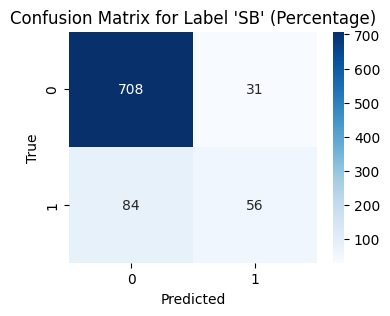

precision: 0.6436781609195402
recall: 0.4
f1: 0.4933920704845815
Confusion Matrix and Metrics for Label '1dAVb':


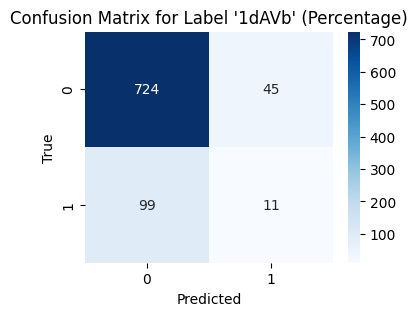

precision: 0.19642857142857142
recall: 0.1
f1: 0.13253012048192772
Confusion Matrix and Metrics for Label 'LBBB':


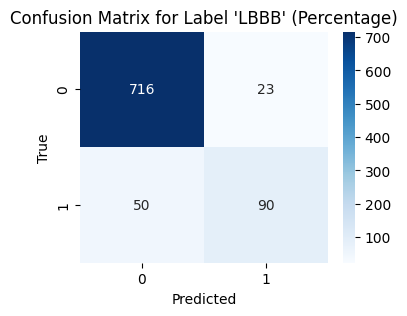

precision: 0.7964601769911505
recall: 0.6428571428571429
f1: 0.7114624505928855
Confusion Matrix and Metrics for Label 'ST':


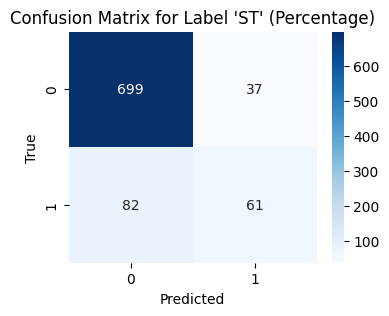

precision: 0.6224489795918368
recall: 0.42657342657342656
f1: 0.5062240663900415
Confusion Matrix and Metrics for Label 'AF':


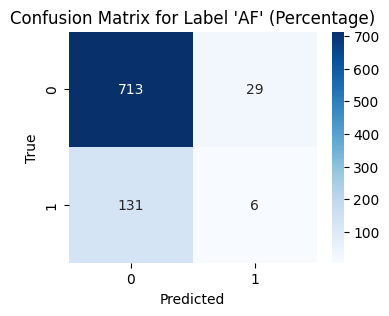

precision: 0.17142857142857143
recall: 0.043795620437956206
f1: 0.06976744186046512
Confusion Matrix and Metrics for Label 'RBBB':


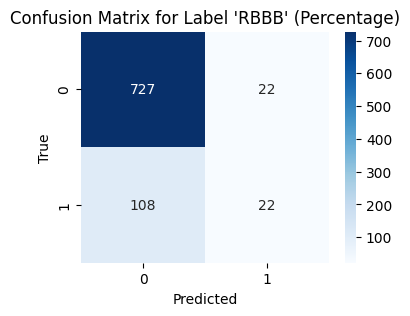

precision: 0.5
recall: 0.16923076923076924
f1: 0.2528735632183908


In [1408]:
multioutput_classifiers['KNN'].fit(X_train, y_train)
y_pred = multioutput_classifiers['KNN'].predict(X_test)
print_metrics(y_test, y_pred)
print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'KNN', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'KNN', 'label': label, **results_per_class[label]} 

In [1187]:
multioutput_classifiers['RandomForest'].fit(X_train, y_train)
y_pred = multioutput_classifiers['RandomForest'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'RandomForest', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'RandomForest', 'label': label, **results_per_class[label]} 

In [1188]:
multioutput_classifiers['LogisticRegression'].fit(X_train, y_train)
y_pred = multioutput_classifiers['LogisticRegression'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LogisticRegression', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LogisticRegression', 'label': label, **results_per_class[label]}

In [1189]:
multioutput_classifiers['DecisionTree'].fit(X_train, y_train)
y_pred = multioutput_classifiers['DecisionTree'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'DecisionTree', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'DecisionTree', 'label': label, **results_per_class[label]}

In [1190]:
multioutput_classifiers['LDA'].fit(X_train, y_train)
y_pred = multioutput_classifiers['LDA'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LDA', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LDA', 'label': label, **results_per_class[label]}

In [1191]:
multioutput_classifiers['QDA'].fit(X_train, y_train)
y_pred = multioutput_classifiers['QDA'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'QDA', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'QDA', 'label': label, **results_per_class[label]}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site

In [1192]:
multioutput_classifiers['SVC'].fit(X_train, y_train)
y_pred = multioutput_classifiers['SVC'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'SVC', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'SVC', 'label': label, **results_per_class[label]}

In [1193]:
df_general_results

,classifier,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro,hamming_loss_value
0,KNN,0.568129,0.488407,0.30750,0.297076,0.399027,0.361042,0.140501
1,RandomForest,0.793210,0.704165,0.32125,0.305965,0.457295,0.376377,0.115662
2,LogisticRegression,0.737542,0.571113,0.27750,0.264082,0.403270,0.331799,0.124573
3,DecisionTree,0.376422,0.377021,0.45500,0.445921,0.411998,0.407238,0.197004
4,LDA,0.710938,0.543530,0.22750,0.216562,0.344697,0.280755,0.131210
5,QDA,0.224757,0.287031,0.75125,0.754166,0.345999,0.381646,0.430793
6,SVC,0.303759,0.283374,0.25250,0.245858,0.275768,0.260682,0.201176


In [1194]:
float_columns = ['precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro', 'hamming_loss_value']
df_general_results[float_columns] = df_general_results[float_columns].round(2)
df_general_results.to_markdown(index=False)

'| classifier         |   precision_micro |   precision_macro |   recall_micro |   recall_macro |   f1_micro |   f1_macro |   hamming_loss_value |\n|:-------------------|------------------:|------------------:|---------------:|---------------:|-----------:|-----------:|---------------------:|\n| KNN                |              0.57 |              0.49 |           0.31 |           0.3  |       0.4  |       0.36 |                 0.14 |\n| RandomForest       |              0.79 |              0.7  |           0.32 |           0.31 |       0.46 |       0.38 |                 0.12 |\n| LogisticRegression |              0.74 |              0.57 |           0.28 |           0.26 |       0.4  |       0.33 |                 0.12 |\n| DecisionTree       |              0.38 |              0.38 |           0.46 |           0.45 |       0.41 |       0.41 |                 0.2  |\n| LDA                |              0.71 |              0.54 |           0.23 |           0.22 |       0.34 |       0

In [1195]:
df_results_per_class

,classifier,label,precision,recall,f1
0,KNN,SB,0.643678,0.400000,0.493392
1,KNN,1dAVb,0.196429,0.100000,0.132530
2,KNN,LBBB,0.796460,0.642857,0.711462
3,KNN,ST,0.622449,0.426573,0.506224
4,KNN,AF,0.171429,0.043796,0.069767
5,KNN,RBBB,0.500000,0.169231,0.252874
6,RandomForest,SB,0.810127,0.457143,0.584475
7,RandomForest,1dAVb,0.166667,0.009091,0.017241
8,RandomForest,LBBB,0.807018,0.657143,0.724409
9,RandomForest,ST,0.774510,0.552448,0.644898


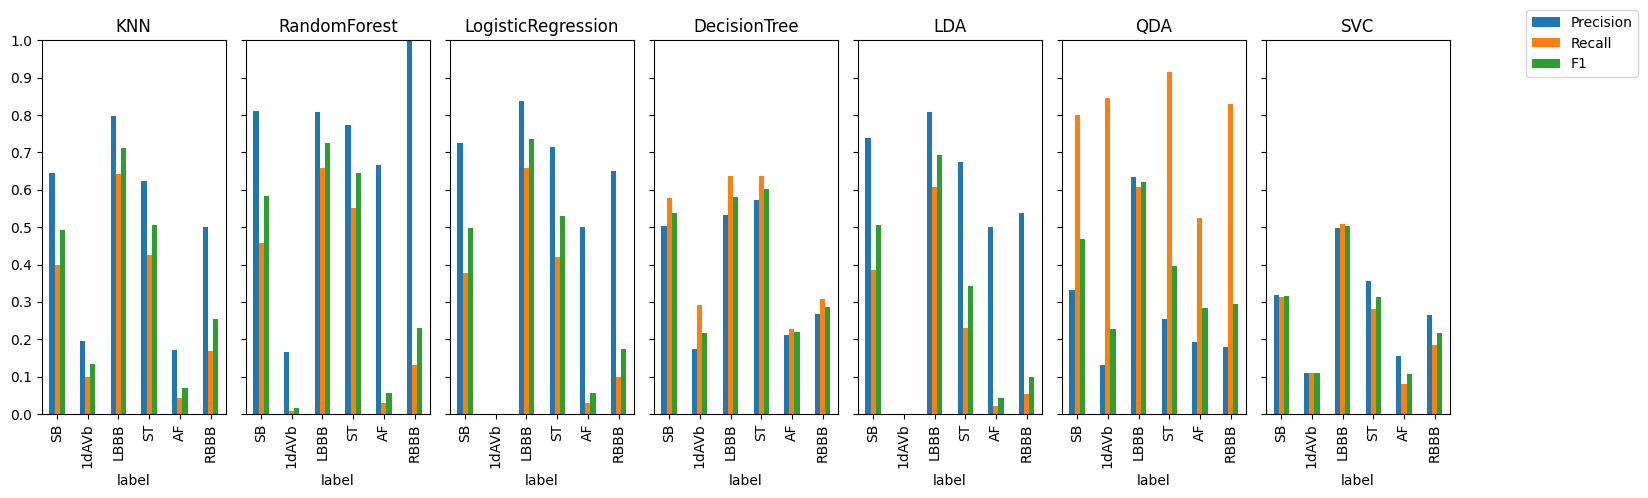

In [1196]:
classifiers = df_results_per_class['classifier'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(classifiers), figsize=(15, 5), sharey=True)

for i, classifier in enumerate(classifiers):
    df_subset = df_results_per_class[df_results_per_class['classifier'] == classifier]
    df_subset.plot(kind='bar', x='label', y=['precision', 'recall', 'f1'], ax=axes[i], title=classifier, legend=False)
    
    axes[i].set_ylim([0, 1])  # Adjust the y-axis range as needed
    
    # Setting y-axis ticks at intervals of 0.1
    axes[i].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

# Adding a common legend outside the subplots
fig.legend(['Precision', 'Recall', 'F1'], bbox_to_anchor=(1.1, 1))

# Adjust layout to prevent clipping of the legend
plt.tight_layout(rect=[0, 0, 0.98, 1])  # Adjust the right margin to make space for the legend

plt.savefig('./images/multioutput_class_comparison_sick_and_healthy.png', bbox_inches='tight')
# Show the plots
plt.show()

In [1197]:
float_columns = ['precision', 'recall', 'f1']
df_results_per_class[float_columns] = df_results_per_class[float_columns].round(2)
df_results_per_class.to_markdown(index=False)

'| classifier         | label   |   precision |   recall |   f1 |\n|:-------------------|:--------|------------:|---------:|-----:|\n| KNN                | SB      |        0.64 |     0.4  | 0.49 |\n| KNN                | 1dAVb   |        0.2  |     0.1  | 0.13 |\n| KNN                | LBBB    |        0.8  |     0.64 | 0.71 |\n| KNN                | ST      |        0.62 |     0.43 | 0.51 |\n| KNN                | AF      |        0.17 |     0.04 | 0.07 |\n| KNN                | RBBB    |        0.5  |     0.17 | 0.25 |\n| RandomForest       | SB      |        0.81 |     0.46 | 0.58 |\n| RandomForest       | 1dAVb   |        0.17 |     0.01 | 0.02 |\n| RandomForest       | LBBB    |        0.81 |     0.66 | 0.72 |\n| RandomForest       | ST      |        0.77 |     0.55 | 0.64 |\n| RandomForest       | AF      |        0.67 |     0.03 | 0.06 |\n| RandomForest       | RBBB    |        1    |     0.13 | 0.23 |\n| LogisticRegression | SB      |        0.73 |     0.38 | 0.5  |\n| Logisti

In [1198]:
numeric_columns = df_results_per_class.select_dtypes(include='number').columns
df_results_per_class.groupby('label')[numeric_columns].mean().round(2).sort_values(by='f1', ascending=True)

,precision,recall,f1
label,,,
1dAVb,0.11,0.19,0.10
AF,0.34,0.14,0.12
RBBB,0.49,0.25,0.22
ST,0.56,0.50,0.48
SB,0.58,0.47,0.49
LBBB,0.70,0.62,0.65


In [1199]:
#df_results_per_class.groupby('label')[numeric_columns].mean()[float_columns].round(2).to_markdown()

In [1200]:
max_precison_index = df_results_per_class['precision'].idxmax()
df_results_per_class.iloc[max_precison_index]

classifier    RandomForest
label                 RBBB
precision              1.0
recall                0.13
f1                    0.23
Name: 11, dtype: object

In [1201]:
max_recall_index = df_results_per_class['recall'].idxmax()
df_results_per_class.iloc[max_recall_index]

classifier     QDA
label           ST
precision     0.25
recall        0.92
f1             0.4
Name: 33, dtype: object

In [1202]:
max_f1_index = df_results_per_class['f1'].idxmax()
df_results_per_class.loc[max_f1_index]

classifier    LogisticRegression
label                       LBBB
precision                   0.84
recall                      0.66
f1                          0.74
Name: 14, dtype: object

In [1203]:
df_results_per_class[df_results_per_class['label'] == 'LBBB']

,classifier,label,precision,recall,f1
2,KNN,LBBB,0.80,0.64,0.71
8,RandomForest,LBBB,0.81,0.66,0.72
14,LogisticRegression,LBBB,0.84,0.66,0.74
20,DecisionTree,LBBB,0.53,0.64,0.58
26,LDA,LBBB,0.81,0.61,0.69
32,QDA,LBBB,0.63,0.61,0.62
38,SVC,LBBB,0.50,0.51,0.50


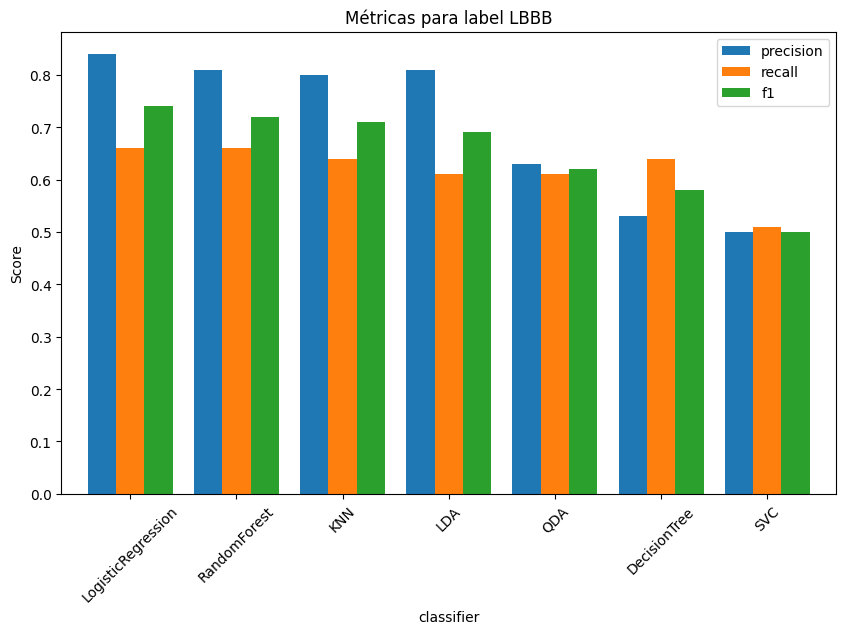

In [1204]:
df_filtered = df_results_per_class[df_results_per_class['label'] == 'LBBB'].sort_values(by='f1', ascending=False)


# Set the classifier as the index for better plotting
df_filtered.set_index('classifier', inplace=True)

# Plotting with rotated x-axis labels
ax = df_filtered[['precision', 'recall', 'f1']].plot(kind='bar', rot=45, figsize=(10, 6), width=0.8)
ax.set_ylabel('Score')
ax.set_title('Métricas para label LBBB')
plt.savefig('./images/multioutput_LBBB_sick_and_healthy.png', bbox_inches='tight')
plt.show()


In [1205]:
#df_results_per_class[df_results_per_class['label'] == 'LBBB'].to_markdown(index=False)

É perceptível que a label mais fácil de classificar é a LBBB. E o classificador que obteve melhor desemplenho ao classificá-la é foi a regressão logística.

In [1206]:
df_results_per_class[df_results_per_class['label'] == 'SB']

,classifier,label,precision,recall,f1
0,KNN,SB,0.64,0.40,0.49
6,RandomForest,SB,0.81,0.46,0.58
12,LogisticRegression,SB,0.73,0.38,0.50
18,DecisionTree,SB,0.50,0.58,0.54
24,LDA,SB,0.74,0.39,0.51
30,QDA,SB,0.33,0.80,0.47
36,SVC,SB,0.32,0.31,0.32


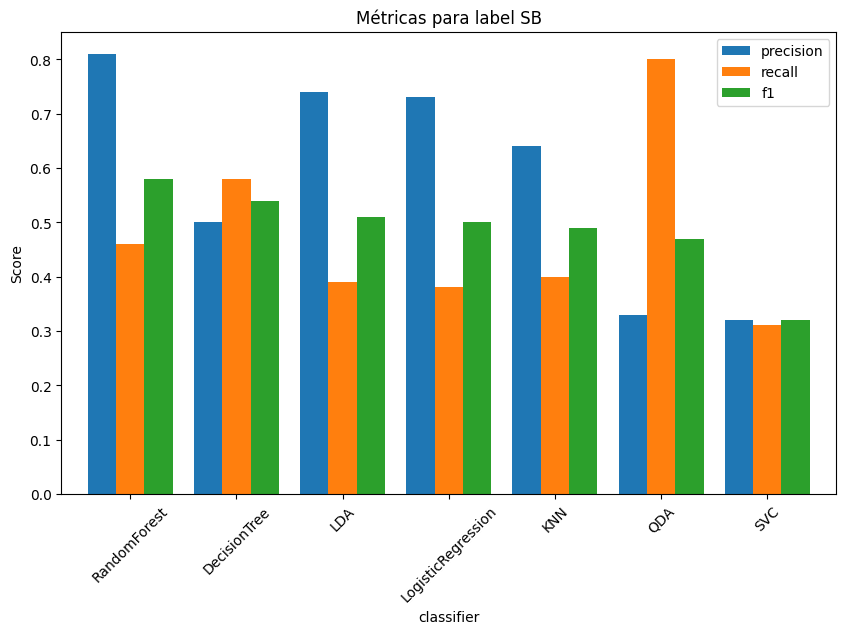

In [1207]:
df_filtered = df_results_per_class[df_results_per_class['label'] == 'SB'].sort_values(by='f1', ascending=False)


# Set the classifier as the index for better plotting
df_filtered.set_index('classifier', inplace=True)

# Plotting with rotated x-axis labels
ax = df_filtered[['precision', 'recall', 'f1']].plot(kind='bar', rot=45, figsize=(10, 6), width=0.8)
ax.set_ylabel('Score')
ax.set_title('Métricas para label SB')
plt.savefig('./images/multioutput_SB_sick_and_healthy.png', bbox_inches='tight')
plt.show()


In [1208]:
df_results_per_class[df_results_per_class['label'] == 'ST']

,classifier,label,precision,recall,f1
3,KNN,ST,0.62,0.43,0.51
9,RandomForest,ST,0.77,0.55,0.64
15,LogisticRegression,ST,0.71,0.42,0.53
21,DecisionTree,ST,0.57,0.64,0.60
27,LDA,ST,0.67,0.23,0.34
33,QDA,ST,0.25,0.92,0.40
39,SVC,ST,0.36,0.28,0.31


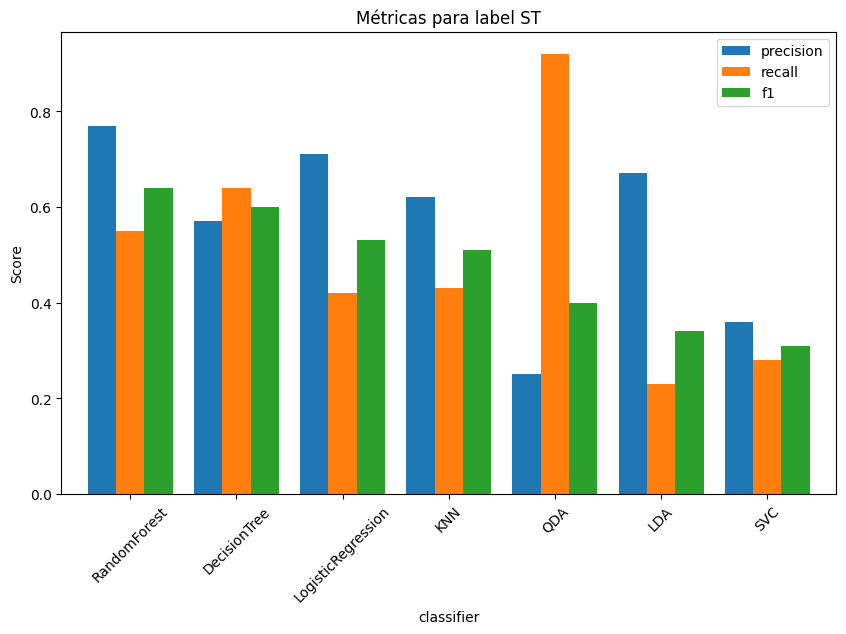

In [1209]:
df_filtered = df_results_per_class[df_results_per_class['label'] == 'ST'].sort_values(by='f1', ascending=False)


# Set the classifier as the index for better plotting
df_filtered.set_index('classifier', inplace=True)

# Plotting with rotated x-axis labels
ax = df_filtered[['precision', 'recall', 'f1']].plot(kind='bar', rot=45, figsize=(10, 6), width=0.8)
ax.set_ylabel('Score')
ax.set_title('Métricas para label ST')
plt.savefig('./images/multioutput_ST_sick_and_healthy.png', bbox_inches='tight')
plt.show()


#### ClassifierChain

In [1410]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1411]:

classifierChain_classifiers = { 
  'KNN': ClassifierChain(KNeighborsClassifier(), random_state=42),
  'RandomForest': ClassifierChain(RandomForestClassifier(criterion='log_loss', random_state=42), random_state=42),
  'LogisticRegression': ClassifierChain(LogisticRegression(max_iter=1000), random_state=42),
  'DecisionTree': ClassifierChain(DecisionTreeClassifier(random_state=42), random_state=42),
  'LDA': ClassifierChain(LinearDiscriminantAnalysis(), random_state=42),
  'QDA': ClassifierChain(QuadraticDiscriminantAnalysis(), random_state=42),
  'SVC': ClassifierChain(SVC(kernel='sigmoid', random_state=42), random_state=42),
                              }
    
    

In [1412]:
df_general_results = pd.DataFrame(columns=['classifier', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro', 'hamming_loss_value'])

In [1413]:
df_results_per_class = pd.DataFrame(columns=['classifier', 'label', 'precision', 'recall', 'f1'])

In [1414]:
y_pred

array([[False, False, False, False, False, False],
       [False,  True, False, False, False, False],
       [False, False, False, False, False, False],
       ...,
       [False, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [1419]:
b = y_pred.copy()
print(b.shape)
print(all(a[:,0] == b[:,0]))


(879, 6)
True


precision micro: 0.5
recall micro: 0.35375
f1 micro: 0.4143484626647145
precision macro: 0.46349832750410447
recall macro: 0.3433846567058246
f1 macro = 0.3918338263818805
hamming loss_value: 0.15168752370117558
Confusion Matrix and Metrics for Label 'SB':


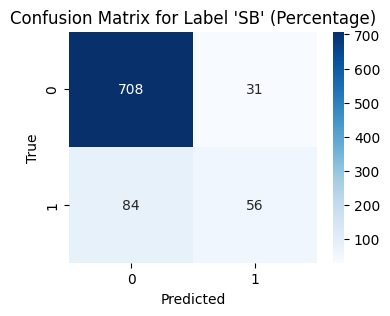

precision: 0.6436781609195402
recall: 0.4
f1: 0.4933920704845815
Confusion Matrix and Metrics for Label '1dAVb':


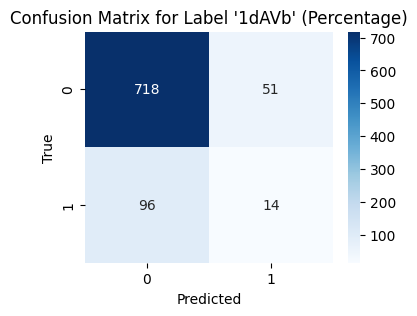

precision: 0.2153846153846154
recall: 0.12727272727272726
f1: 0.16
Confusion Matrix and Metrics for Label 'LBBB':


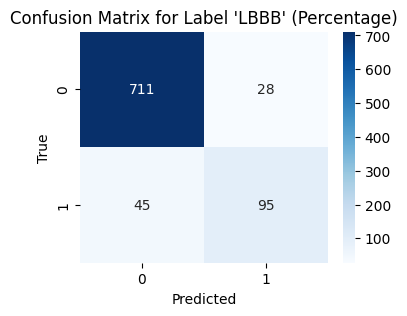

precision: 0.7723577235772358
recall: 0.6785714285714286
f1: 0.7224334600760456
Confusion Matrix and Metrics for Label 'ST':


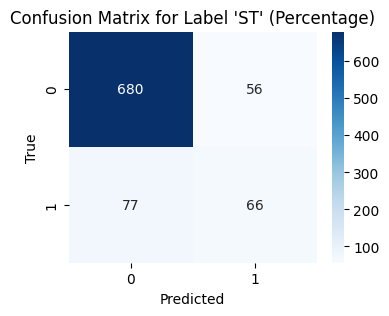

precision: 0.5409836065573771
recall: 0.46153846153846156
f1: 0.49811320754716987
Confusion Matrix and Metrics for Label 'AF':


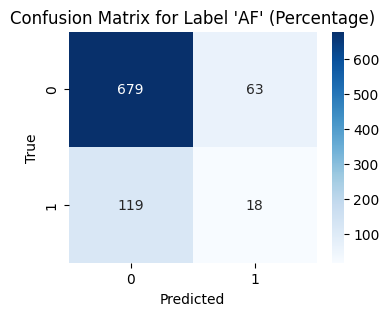

precision: 0.2222222222222222
recall: 0.13138686131386862
f1: 0.1651376146788991
Confusion Matrix and Metrics for Label 'RBBB':


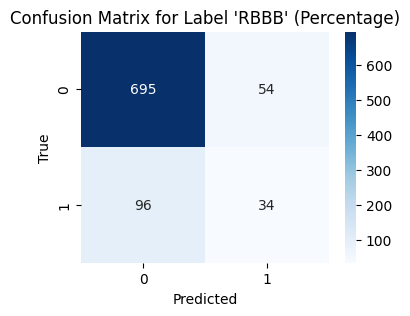

precision: 0.38636363636363635
recall: 0.26153846153846155
f1: 0.3119266055045871


In [1416]:
classifierChain_classifiers['KNN'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['KNN'].predict(X_test)
print_metrics(y_test, y_pred)
print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'KNN', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'KNN', 'label': label, **results_per_class[label]} 

In [1215]:
classifierChain_classifiers['RandomForest'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['RandomForest'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'RandomForest', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'RandomForest', 'label': label, **results_per_class[label]} 

In [1216]:
classifierChain_classifiers['LogisticRegression'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['LogisticRegression'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LogisticRegression', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LogisticRegression', 'label': label, **results_per_class[label]}

In [1217]:
classifierChain_classifiers['DecisionTree'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['DecisionTree'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'DecisionTree', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'DecisionTree', 'label': label, **results_per_class[label]}

In [1218]:
classifierChain_classifiers['LDA'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['LDA'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LDA', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LDA', 'label': label, **results_per_class[label]}

In [1219]:
classifierChain_classifiers['QDA'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['QDA'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'QDA', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'QDA', 'label': label, **results_per_class[label]}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site

In [1220]:
classifierChain_classifiers['SVC'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['SVC'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'SVC', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'SVC', 'label': label, **results_per_class[label]}

In [1221]:
df_general_results

,classifier,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro,hamming_loss_value
0,KNN,0.500000,0.463498,0.35375,0.343385,0.414348,0.391834,0.151688
1,RandomForest,0.739726,0.628556,0.33750,0.322732,0.463519,0.402862,0.118506
2,LogisticRegression,0.663366,0.556053,0.33500,0.322117,0.445183,0.394570,0.126659
3,DecisionTree,0.362541,0.364423,0.41375,0.402660,0.386457,0.381634,0.199279
4,LDA,0.606684,0.513067,0.29500,0.284711,0.396972,0.355120,0.135950
5,QDA,0.249347,0.300311,0.59625,0.596424,0.351640,0.345160,0.333523
6,SVC,0.289037,0.273134,0.21750,0.213002,0.248217,0.234980,0.199848


In [1222]:
float_columns = ['precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro', 'hamming_loss_value']
df_general_results[float_columns] = df_general_results[float_columns].round(2)
#df_general_results.to_markdown(index=False)

In [1223]:
df_results_per_class

,classifier,label,precision,recall,f1
0,KNN,SB,0.643678,0.400000,0.493392
1,KNN,1dAVb,0.215385,0.127273,0.160000
2,KNN,LBBB,0.772358,0.678571,0.722433
3,KNN,ST,0.540984,0.461538,0.498113
4,KNN,AF,0.222222,0.131387,0.165138
5,KNN,RBBB,0.386364,0.261538,0.311927
6,RandomForest,SB,0.810127,0.457143,0.584475
7,RandomForest,1dAVb,0.133333,0.018182,0.032000
8,RandomForest,LBBB,0.787611,0.635714,0.703557
9,RandomForest,ST,0.772277,0.545455,0.639344


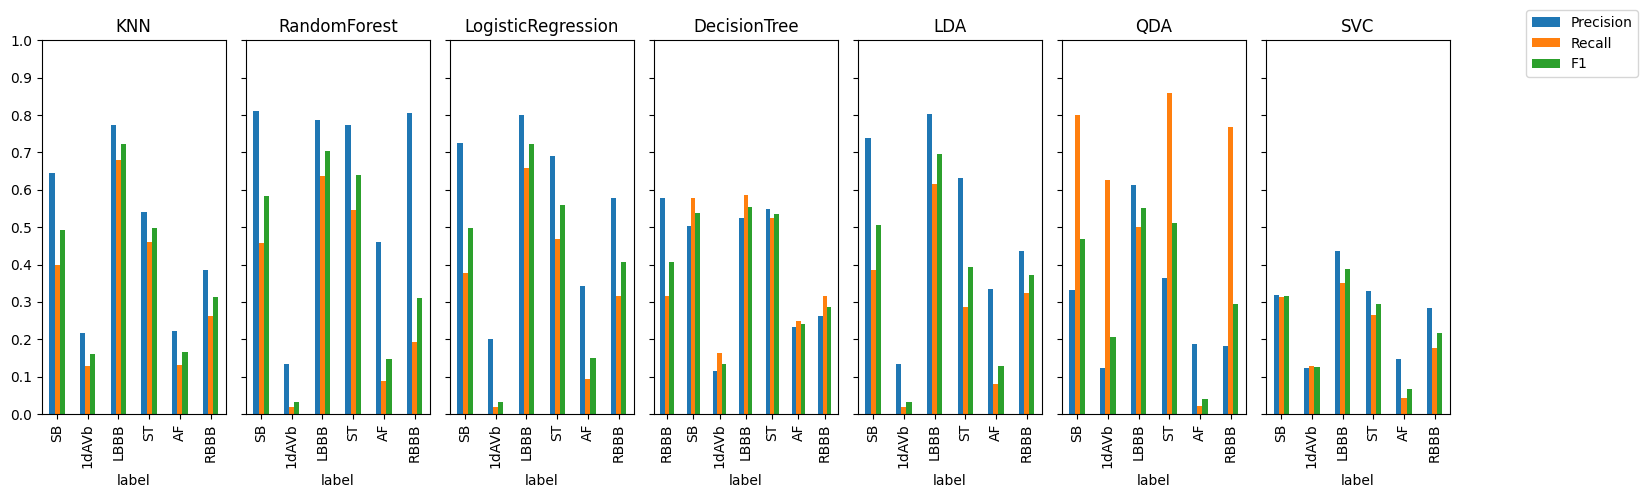

In [1224]:
classifiers = df_results_per_class['classifier'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(classifiers), figsize=(15, 5), sharey=True)

for i, classifier in enumerate(classifiers):
    df_subset = df_results_per_class[df_results_per_class['classifier'] == classifier]
    df_subset.plot(kind='bar', x='label', y=['precision', 'recall', 'f1'], ax=axes[i], title=classifier, legend=False)
    
    axes[i].set_ylim([0, 1])  # Adjust the y-axis range as needed
    
    # Setting y-axis ticks at intervals of 0.1
    axes[i].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

# Adding a common legend outside the subplots
fig.legend(['Precision', 'Recall', 'F1'], bbox_to_anchor=(1.1, 1))

# Adjust layout to prevent clipping of the legend
plt.tight_layout(rect=[0, 0, 0.98, 1])  # Adjust the right margin to make space for the legend

plt.savefig('./images/classifierchain_class_comparison_sick_and_healthy.png', bbox_inches='tight')
# Show the plots
plt.show()

In [1225]:
float_columns = ['precision', 'recall', 'f1']
df_results_per_class[float_columns] = df_results_per_class[float_columns].round(2)
#df_results_per_class.to_markdown(index=False)

In [1226]:
numeric_columns = df_results_per_class.select_dtypes(include='number').columns
df_results_per_class.groupby('label')[numeric_columns].mean()[float_columns].round(2)

,precision,recall,f1
label,,,
1dAVb,0.15,0.16,0.10
AF,0.27,0.10,0.14
LBBB,0.68,0.58,0.62
RBBB,0.44,0.34,0.33
SB,0.58,0.47,0.49
ST,0.55,0.49,0.49


In [1227]:
#df_results_per_class.groupby('label')[numeric_columns].mean()[float_columns].round(2).to_markdown()

In [1228]:
max_precison_index = df_results_per_class['precision'].idxmax()
df_results_per_class.iloc[max_precison_index]

classifier    RandomForest
label                   SB
precision             0.81
recall                0.46
f1                    0.58
Name: 6, dtype: object

In [1229]:
max_recall_index = df_results_per_class['recall'].idxmax()
df_results_per_class.iloc[max_recall_index]

classifier     QDA
label           ST
precision     0.36
recall        0.86
f1            0.51
Name: 34, dtype: object

In [1230]:
max_f1_index = df_results_per_class['f1'].idxmax()
df_results_per_class.loc[max_f1_index]

classifier     KNN
label         LBBB
precision     0.77
recall        0.68
f1            0.72
Name: 2, dtype: object

In [1231]:
df_results_per_class[df_results_per_class['label'] == 'LBBB']

,classifier,label,precision,recall,f1
2,KNN,LBBB,0.77,0.68,0.72
8,RandomForest,LBBB,0.79,0.64,0.70
14,LogisticRegression,LBBB,0.80,0.66,0.72
21,DecisionTree,LBBB,0.53,0.59,0.55
27,LDA,LBBB,0.80,0.61,0.70
33,QDA,LBBB,0.61,0.50,0.55
39,SVC,LBBB,0.44,0.35,0.39


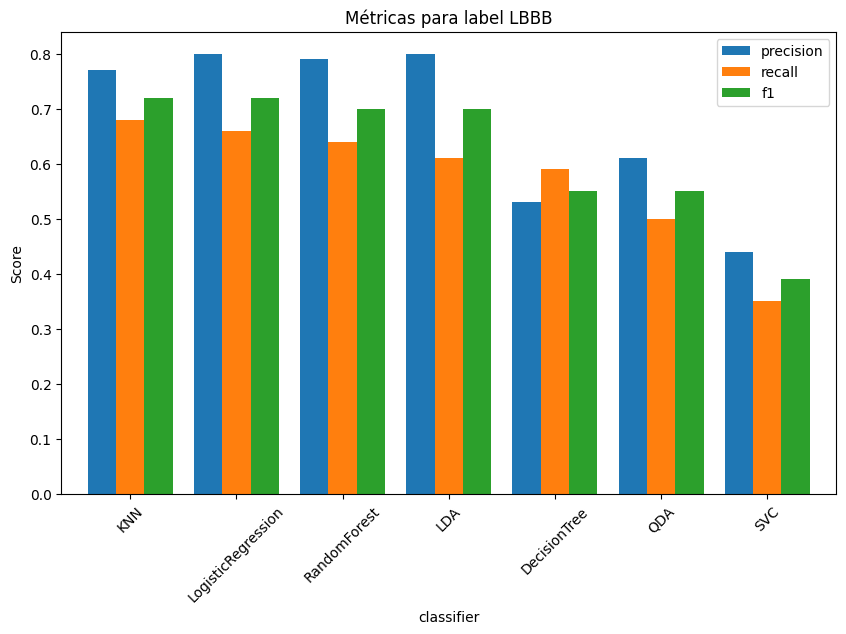

In [1232]:
df_filtered = df_results_per_class[df_results_per_class['label'] == 'LBBB'].sort_values(by='f1', ascending=False)


# Set the classifier as the index for better plotting
df_filtered.set_index('classifier', inplace=True)

# Plotting with rotated x-axis labels
ax = df_filtered[['precision', 'recall', 'f1']].plot(kind='bar', rot=45, figsize=(10, 6), width=0.8)
ax.set_ylabel('Score')
ax.set_title('Métricas para label LBBB')
plt.savefig('./images/classifierchain_LBBB_sick_and_healthy.png', bbox_inches='tight')
plt.show()


In [1233]:
#df_results_per_class[df_results_per_class['label'] == 'LBBB'].to_markdown(index=False)

In [1234]:
df_results_per_class[df_results_per_class['label'] == 'SB']

,classifier,label,precision,recall,f1
0,KNN,SB,0.64,0.40,0.49
6,RandomForest,SB,0.81,0.46,0.58
12,LogisticRegression,SB,0.73,0.38,0.50
19,DecisionTree,SB,0.50,0.58,0.54
25,LDA,SB,0.74,0.39,0.51
31,QDA,SB,0.33,0.80,0.47
37,SVC,SB,0.32,0.31,0.32


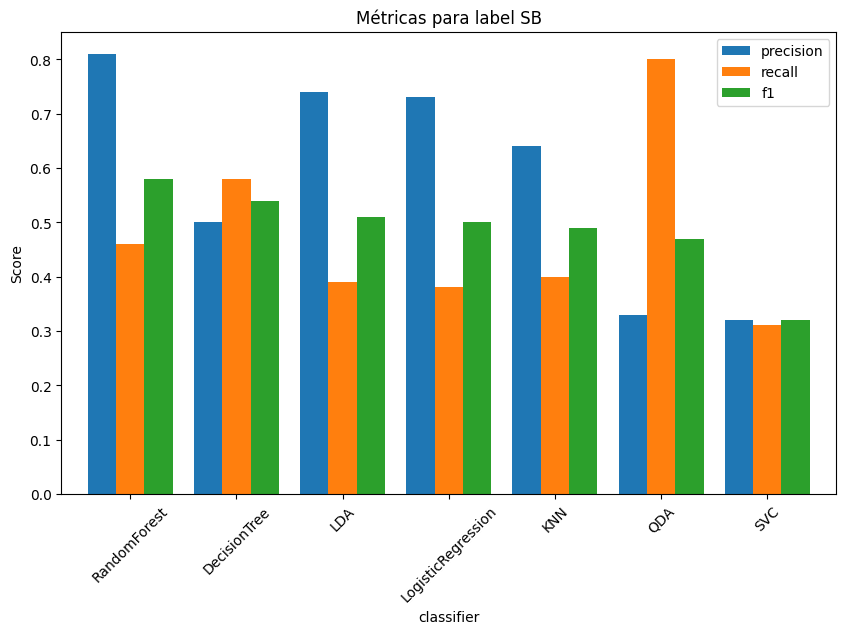

In [1235]:
df_filtered = df_results_per_class[df_results_per_class['label'] == 'SB'].sort_values(by='f1', ascending=False)


# Set the classifier as the index for better plotting
df_filtered.set_index('classifier', inplace=True)

# Plotting with rotated x-axis labels
ax = df_filtered[['precision', 'recall', 'f1']].plot(kind='bar', rot=45, figsize=(10, 6), width=0.8)
ax.set_ylabel('Score')
ax.set_title('Métricas para label SB')
plt.savefig('./images/classifierchain_SB_sick_and_healthy.png', bbox_inches='tight')
plt.show()


In [1236]:
df_results_per_class[df_results_per_class['label'] == 'ST']

,classifier,label,precision,recall,f1
3,KNN,ST,0.54,0.46,0.50
9,RandomForest,ST,0.77,0.55,0.64
15,LogisticRegression,ST,0.69,0.47,0.56
22,DecisionTree,ST,0.55,0.52,0.54
28,LDA,ST,0.63,0.29,0.39
34,QDA,ST,0.36,0.86,0.51
40,SVC,ST,0.33,0.27,0.29


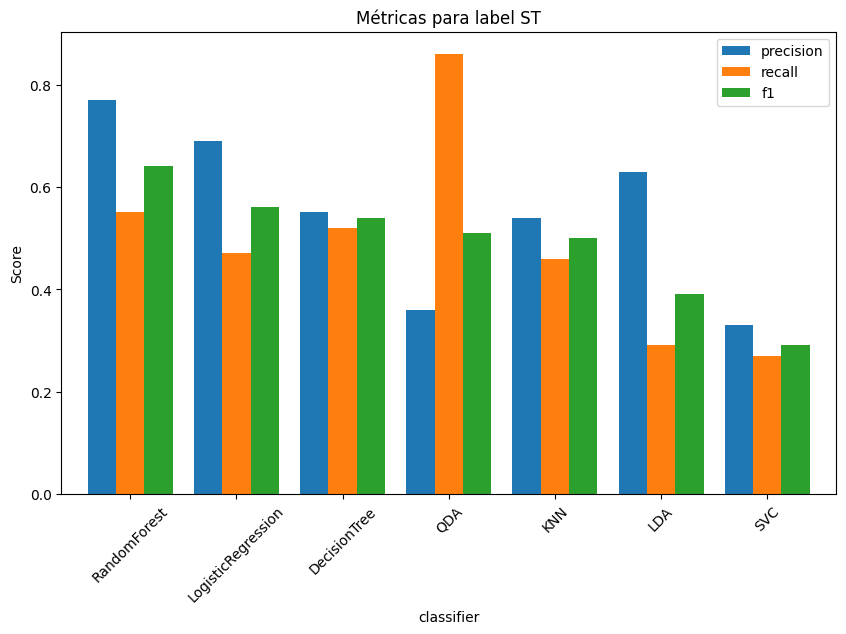

In [1237]:
df_filtered = df_results_per_class[df_results_per_class['label'] == 'ST'].sort_values(by='f1', ascending=False)


# Set the classifier as the index for better plotting
df_filtered.set_index('classifier', inplace=True)

# Plotting with rotated x-axis labels
ax = df_filtered[['precision', 'recall', 'f1']].plot(kind='bar', rot=45, figsize=(10, 6), width=0.8)
ax.set_ylabel('Score')
ax.set_title('Métricas para label ST')
plt.savefig('./images/classifierchain_ST_sick_and_healthy.png', bbox_inches='tight')
plt.show()


### Conjunto de dados somente com doentes

#### MultioutputClassifier

In [1238]:
X_train, X_test, y_train, y_test = train_test_split(X_sick, y_sick, test_size=0.2, random_state=42)

In [1239]:

multioutput_classifiers = { 
  'KNN': MultiOutputClassifier(KNeighborsClassifier()),
  'RandomForest': MultiOutputClassifier(RandomForestClassifier(criterion='log_loss', random_state=42)),
  'LogisticRegression': MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42)),
  'DecisionTree': MultiOutputClassifier(DecisionTreeClassifier(random_state=42)),
  'LDA': MultiOutputClassifier(LinearDiscriminantAnalysis()),
  'QDA': MultiOutputClassifier(QuadraticDiscriminantAnalysis()),
  'SVC': MultiOutputClassifier(SVC(kernel='sigmoid', random_state=42)),
                              }
    
    

In [1240]:
df_general_results = pd.DataFrame(columns=['classifier', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro', 'hamming_loss_value'])

In [1241]:
df_results_per_class = pd.DataFrame(columns=['classifier', 'label', 'precision', 'recall', 'f1'])

In [1242]:
multioutput_classifiers['KNN'].fit(X_train, y_train)
y_pred = multioutput_classifiers['KNN'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'KNN', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'KNN', 'label': label, **results_per_class[label]} 

In [1243]:
multioutput_classifiers['RandomForest'].fit(X_train, y_train)
y_pred = multioutput_classifiers['RandomForest'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'RandomForest', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'RandomForest', 'label': label, **results_per_class[label]} 

In [1244]:
multioutput_classifiers['LogisticRegression'].fit(X_train, y_train)
y_pred = multioutput_classifiers['LogisticRegression'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LogisticRegression', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LogisticRegression', 'label': label, **results_per_class[label]}

In [1245]:
multioutput_classifiers['DecisionTree'].fit(X_train, y_train)
y_pred = multioutput_classifiers['DecisionTree'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'DecisionTree', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'DecisionTree', 'label': label, **results_per_class[label]}

In [1246]:
multioutput_classifiers['LDA'].fit(X_train, y_train)
y_pred = multioutput_classifiers['LDA'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LDA', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LDA', 'label': label, **results_per_class[label]}

In [1247]:
multioutput_classifiers['QDA'].fit(X_train, y_train)
y_pred = multioutput_classifiers['QDA'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'QDA', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'QDA', 'label': label, **results_per_class[label]}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site

In [1248]:
multioutput_classifiers['SVC'].fit(X_train, y_train)
y_pred = multioutput_classifiers['SVC'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'SVC', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'SVC', 'label': label, **results_per_class[label]}

In [1249]:
df_general_results

,classifier,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro,hamming_loss_value
0,KNN,0.592593,0.555655,0.387409,0.391093,0.468521,0.441902,0.165981
1,RandomForest,0.768448,0.723375,0.365617,0.367318,0.495488,0.440138,0.140604
2,LogisticRegression,0.762763,0.663713,0.307506,0.309643,0.438309,0.377536,0.148834
3,DecisionTree,0.462810,0.468528,0.474576,0.476461,0.468619,0.471876,0.203246
4,LDA,0.740484,0.648298,0.259080,0.263407,0.383857,0.330497,0.157064
5,QDA,0.297170,0.361433,0.686441,0.687359,0.414777,0.427520,0.365798
6,SVC,0.345038,0.337634,0.273608,0.275161,0.305199,0.301081,0.235254


In [1250]:
float_columns = ['precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro', 'hamming_loss_value']
df_general_results[float_columns] = df_general_results[float_columns].round(2)
df_general_results.to_markdown(index=False)

'| classifier         |   precision_micro |   precision_macro |   recall_micro |   recall_macro |   f1_micro |   f1_macro |   hamming_loss_value |\n|:-------------------|------------------:|------------------:|---------------:|---------------:|-----------:|-----------:|---------------------:|\n| KNN                |              0.59 |              0.56 |           0.39 |           0.39 |       0.47 |       0.44 |                 0.17 |\n| RandomForest       |              0.77 |              0.72 |           0.37 |           0.37 |       0.5  |       0.44 |                 0.14 |\n| LogisticRegression |              0.76 |              0.66 |           0.31 |           0.31 |       0.44 |       0.38 |                 0.15 |\n| DecisionTree       |              0.46 |              0.47 |           0.47 |           0.48 |       0.47 |       0.47 |                 0.2  |\n| LDA                |              0.74 |              0.65 |           0.26 |           0.26 |       0.38 |       0

In [1251]:
df_results_per_class

,classifier,label,precision,recall,f1
0,KNN,SB,0.711538,0.582677,0.640693
1,KNN,1dAVb,0.344828,0.232558,0.277778
2,KNN,LBBB,0.750000,0.694030,0.720930
3,KNN,ST,0.619403,0.560811,0.588652
4,KNN,AF,0.265306,0.091549,0.136126
5,KNN,RBBB,0.642857,0.184932,0.287234
6,RandomForest,SB,0.863636,0.598425,0.706977
7,RandomForest,1dAVb,0.428571,0.069767,0.120000
8,RandomForest,LBBB,0.764706,0.679104,0.719368
9,RandomForest,ST,0.750000,0.608108,0.671642


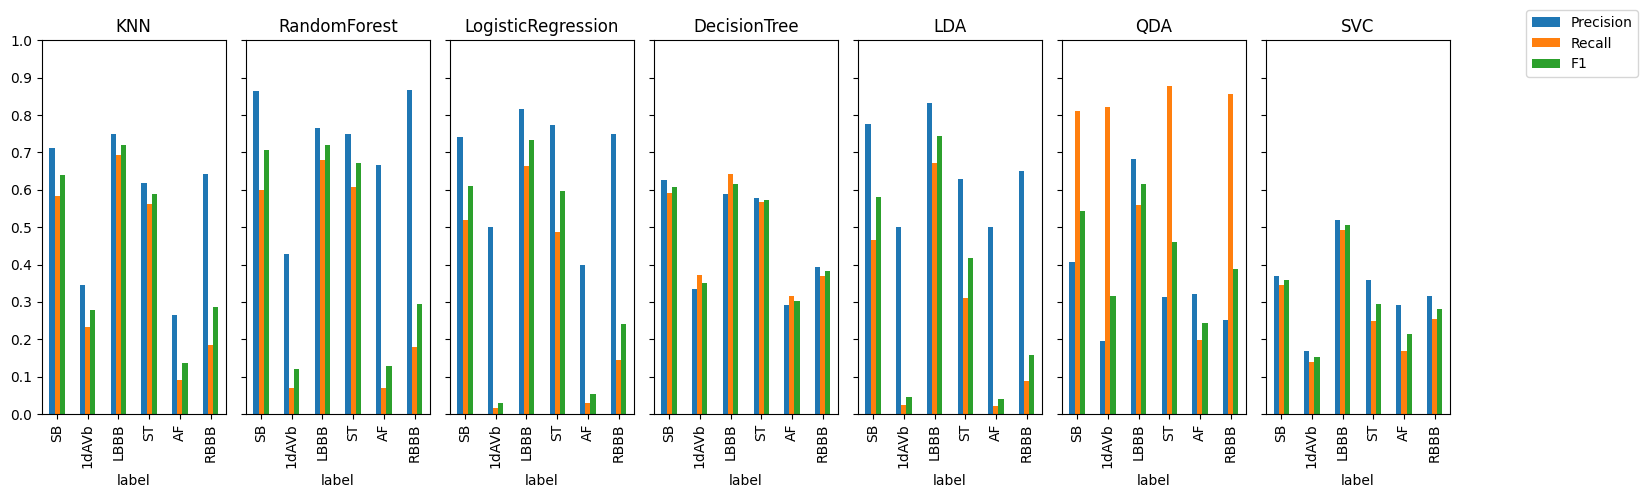

In [1252]:
classifiers = df_results_per_class['classifier'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(classifiers), figsize=(15, 5), sharey=True)

for i, classifier in enumerate(classifiers):
    df_subset = df_results_per_class[df_results_per_class['classifier'] == classifier]
    df_subset.plot(kind='bar', x='label', y=['precision', 'recall', 'f1'], ax=axes[i], title=classifier, legend=False)
    
    axes[i].set_ylim([0, 1])  # Adjust the y-axis range as needed
    
    # Setting y-axis ticks at intervals of 0.1
    axes[i].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

# Adding a common legend outside the subplots
fig.legend(['Precision', 'Recall', 'F1'], bbox_to_anchor=(1.1, 1))

# Adjust layout to prevent clipping of the legend
plt.tight_layout(rect=[0, 0, 0.98, 1])  # Adjust the right margin to make space for the legend

plt.savefig('./images/multioutput_class_comparison_sick_only.png', bbox_inches='tight')
# Show the plots
plt.show()

In [1253]:
float_columns = ['precision', 'recall', 'f1']
df_results_per_class[float_columns] = df_results_per_class[float_columns].round(2)
df_results_per_class.to_markdown(index=False)

'| classifier         | label   |   precision |   recall |   f1 |\n|:-------------------|:--------|------------:|---------:|-----:|\n| KNN                | SB      |        0.71 |     0.58 | 0.64 |\n| KNN                | 1dAVb   |        0.34 |     0.23 | 0.28 |\n| KNN                | LBBB    |        0.75 |     0.69 | 0.72 |\n| KNN                | ST      |        0.62 |     0.56 | 0.59 |\n| KNN                | AF      |        0.27 |     0.09 | 0.14 |\n| KNN                | RBBB    |        0.64 |     0.18 | 0.29 |\n| RandomForest       | SB      |        0.86 |     0.6  | 0.71 |\n| RandomForest       | 1dAVb   |        0.43 |     0.07 | 0.12 |\n| RandomForest       | LBBB    |        0.76 |     0.68 | 0.72 |\n| RandomForest       | ST      |        0.75 |     0.61 | 0.67 |\n| RandomForest       | AF      |        0.67 |     0.07 | 0.13 |\n| RandomForest       | RBBB    |        0.87 |     0.18 | 0.3  |\n| LogisticRegression | SB      |        0.74 |     0.52 | 0.61 |\n| Logisti

In [1254]:
numeric_columns = df_results_per_class.select_dtypes(include='number').columns
df_results_per_class.groupby('label')[numeric_columns].mean()[float_columns].round(2).sort_values(by='f1', ascending=True)

,precision,recall,f1
label,,,
AF,0.39,0.13,0.16
1dAVb,0.35,0.24,0.18
RBBB,0.55,0.30,0.29
ST,0.57,0.52,0.51
SB,0.64,0.56,0.58
LBBB,0.71,0.63,0.66


In [1255]:
#f_results_per_class.groupby('label')[numeric_columns].mean()[float_columns].round(2).to_markdown()

In [1256]:
max_precison_index = df_results_per_class['precision'].idxmax()
df_results_per_class.iloc[max_precison_index]

classifier    RandomForest
label                 RBBB
precision             0.87
recall                0.18
f1                     0.3
Name: 11, dtype: object

In [1257]:
max_recall_index = df_results_per_class['recall'].idxmax()
df_results_per_class.iloc[max_recall_index]

classifier     QDA
label           ST
precision     0.31
recall        0.88
f1            0.46
Name: 33, dtype: object

In [1258]:
max_f1_index = df_results_per_class['f1'].idxmax()
df_results_per_class.loc[max_f1_index]

classifier     LDA
label         LBBB
precision     0.83
recall        0.67
f1            0.74
Name: 26, dtype: object

In [1259]:
df_results_per_class[df_results_per_class['label'] == 'LBBB']

,classifier,label,precision,recall,f1
2,KNN,LBBB,0.75,0.69,0.72
8,RandomForest,LBBB,0.76,0.68,0.72
14,LogisticRegression,LBBB,0.82,0.66,0.73
20,DecisionTree,LBBB,0.59,0.64,0.61
26,LDA,LBBB,0.83,0.67,0.74
32,QDA,LBBB,0.68,0.56,0.61
38,SVC,LBBB,0.52,0.49,0.51


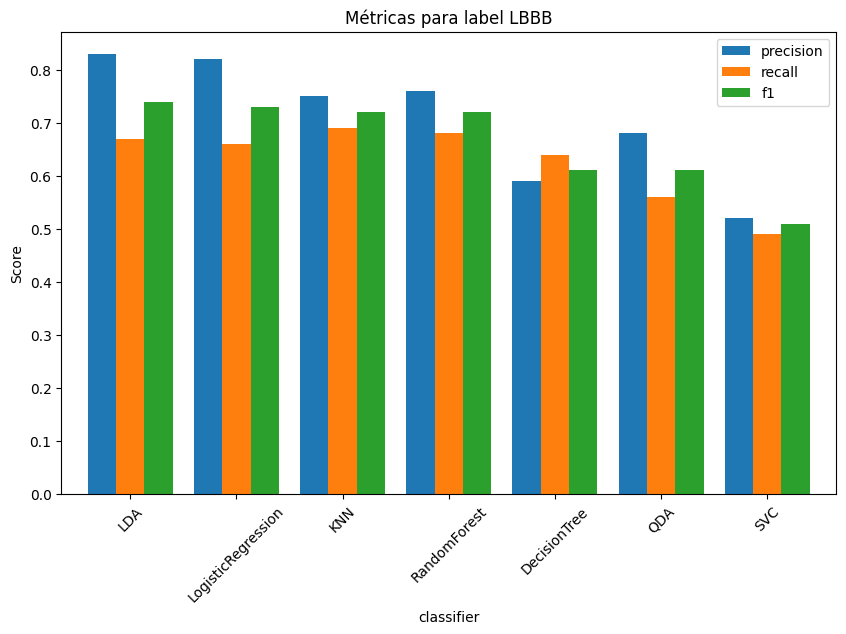

In [1260]:
df_filtered = df_results_per_class[df_results_per_class['label'] == 'LBBB'].sort_values(by='f1', ascending=False)


# Set the classifier as the index for better plotting
df_filtered.set_index('classifier', inplace=True)

# Plotting with rotated x-axis labels
ax = df_filtered[['precision', 'recall', 'f1']].plot(kind='bar', rot=45, figsize=(10, 6), width=0.8)
ax.set_ylabel('Score')
ax.set_title('Métricas para label LBBB')
plt.savefig('./images/multioutput_LBBB_sick_only.png', bbox_inches='tight')
plt.show()


In [1261]:
#df_results_per_class[df_results_per_class['label'] == 'LBBB'].to_markdown(index=False)

Novamente, se confirma que a label mais fácil de classificar é a LBBB. E o classificador que obteve melhor desemplenho ao classificá-la dessa vez foi a análise discriminante.

In [1262]:
df_results_per_class[df_results_per_class['label'] == 'SB']

,classifier,label,precision,recall,f1
0,KNN,SB,0.71,0.58,0.64
6,RandomForest,SB,0.86,0.60,0.71
12,LogisticRegression,SB,0.74,0.52,0.61
18,DecisionTree,SB,0.62,0.59,0.61
24,LDA,SB,0.78,0.46,0.58
30,QDA,SB,0.41,0.81,0.54
36,SVC,SB,0.37,0.35,0.36


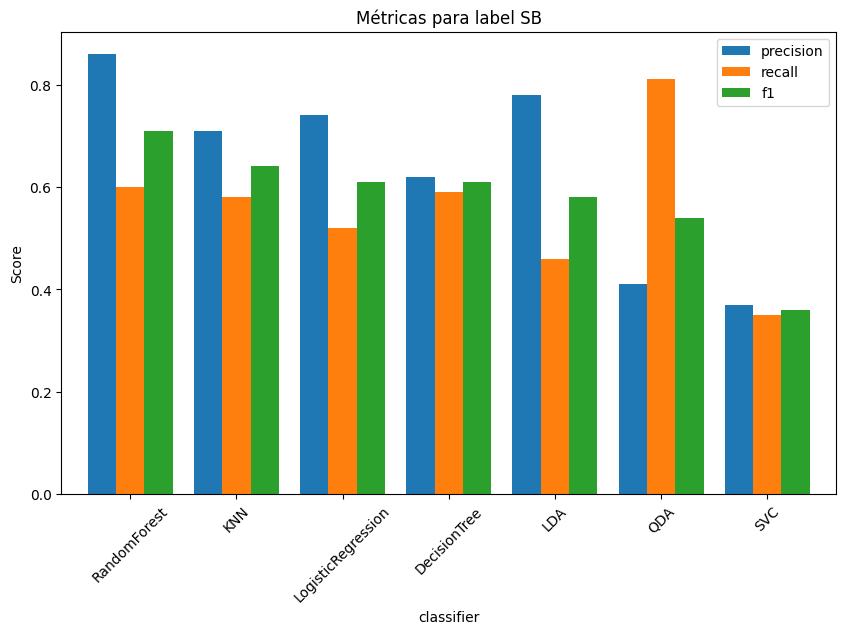

In [1263]:
df_filtered = df_results_per_class[df_results_per_class['label'] == 'SB'].sort_values(by='f1', ascending=False)


# Set the classifier as the index for better plotting
df_filtered.set_index('classifier', inplace=True)

# Plotting with rotated x-axis labels
ax = df_filtered[['precision', 'recall', 'f1']].plot(kind='bar', rot=45, figsize=(10, 6), width=0.8)
ax.set_ylabel('Score')
ax.set_title('Métricas para label SB')
plt.savefig('./images/multioutput_SB_sick_only.png', bbox_inches='tight')
plt.show()

In [1264]:
df_results_per_class[df_results_per_class['label'] == 'ST']

,classifier,label,precision,recall,f1
3,KNN,ST,0.62,0.56,0.59
9,RandomForest,ST,0.75,0.61,0.67
15,LogisticRegression,ST,0.77,0.49,0.60
21,DecisionTree,ST,0.58,0.57,0.57
27,LDA,ST,0.63,0.31,0.42
33,QDA,ST,0.31,0.88,0.46
39,SVC,ST,0.36,0.25,0.29


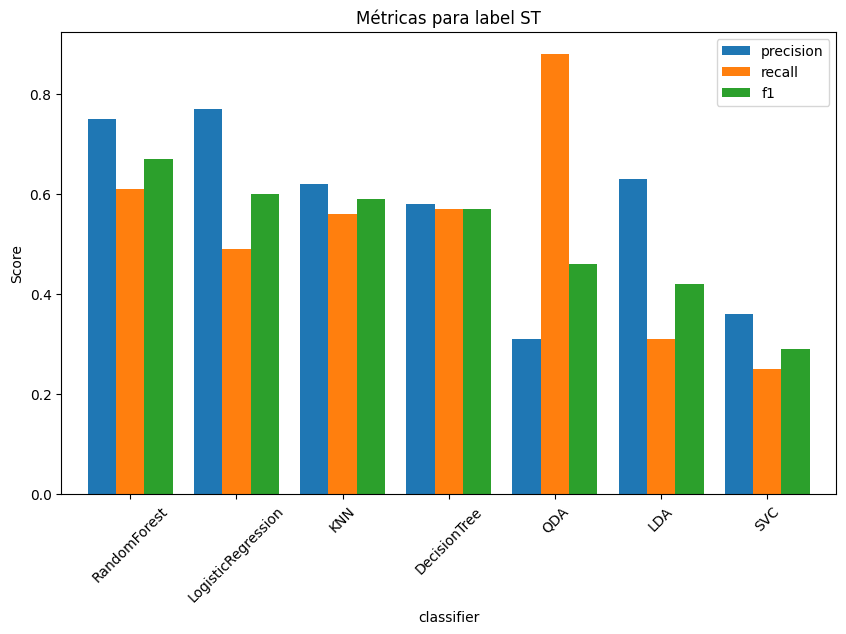

In [1265]:
df_filtered = df_results_per_class[df_results_per_class['label'] == 'ST'].sort_values(by='f1', ascending=False)


# Set the classifier as the index for better plotting
df_filtered.set_index('classifier', inplace=True)

# Plotting with rotated x-axis labels
ax = df_filtered[['precision', 'recall', 'f1']].plot(kind='bar', rot=45, figsize=(10, 6), width=0.8)
ax.set_ylabel('Score')
ax.set_title('Métricas para label ST')
plt.savefig('./images/multioutput_ST_sick_only.png', bbox_inches='tight')
plt.show()


In [1266]:
#df_results_per_class[df_results_per_class['label'] == 'ST'].to_markdown(index=False)

Uma outra observação interessante é que a label SB tem valores de precisão, revocação e f1 interessantes, quando se analisa só amostras doentes.

#### ClassifierChain

In [1267]:
X_train, X_test, y_train, y_test = train_test_split(X_sick, y_sick, test_size=0.2, random_state=42)

In [1268]:

classifierChain_classifiers = { 
  'KNN': ClassifierChain(KNeighborsClassifier(), random_state=42),
  'RandomForest': ClassifierChain(RandomForestClassifier(criterion='log_loss', random_state=42), random_state=42),
  'LogisticRegression': ClassifierChain(LogisticRegression(max_iter=1000), random_state=42),
  'DecisionTree': ClassifierChain(DecisionTreeClassifier(random_state=42), random_state=42),
  'LDA': ClassifierChain(LinearDiscriminantAnalysis(), random_state=42),
  'QDA': ClassifierChain(QuadraticDiscriminantAnalysis(), random_state=42),
  'SVC': ClassifierChain(SVC(kernel='sigmoid', random_state=42), random_state=42),
                              }
    
    

In [1269]:
df_general_results = pd.DataFrame(columns=['classifier', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro', 'hamming_loss_value'])

In [1270]:
df_results_per_class = pd.DataFrame(columns=['classifier', 'label', 'precision', 'recall', 'f1'])

In [1271]:
classifierChain_classifiers['KNN'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['KNN'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'KNN', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'KNN', 'label': label, **results_per_class[label]} 

In [1272]:
classifierChain_classifiers['RandomForest'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['RandomForest'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'RandomForest', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'RandomForest', 'label': label, **results_per_class[label]} 

In [1273]:
classifierChain_classifiers['LogisticRegression'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['LogisticRegression'].predict(X_test)
# print_metrics(y_test, y_pred)
# print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LogisticRegression', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LogisticRegression', 'label': label, **results_per_class[label]}

In [1274]:
classifierChain_classifiers['DecisionTree'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['DecisionTree'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'DecisionTree', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'DecisionTree', 'label': label, **results_per_class[label]}

In [1275]:
classifierChain_classifiers['LDA'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['LDA'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'LDA', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'LDA', 'label': label, **results_per_class[label]}

In [1276]:
classifierChain_classifiers['QDA'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['QDA'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'QDA', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'QDA', 'label': label, **results_per_class[label]}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site

In [1277]:
classifierChain_classifiers['SVC'].fit(X_train, y_train)
y_pred = classifierChain_classifiers['SVC'].predict(X_test)
#print_metrics(y_test, y_pred)
#print_metrics_per_class(y_test, y_pred)
df_general_results.loc[len(df_general_results)] = {'classifier': 'SVC', **get_metrics(y_test, y_pred)}
results_per_class = get_metrics_per_class(y_test, y_pred)
for label in results_per_class:
    df_results_per_class.loc[len(df_results_per_class)] = {'classifier': 'SVC', 'label': label, **results_per_class[label]}

In [1278]:
df_general_results

,classifier,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro,hamming_loss_value
0,KNN,0.540230,0.528839,0.455206,0.456687,0.494087,0.482380,0.176040
1,RandomForest,0.656146,0.632528,0.478208,0.476160,0.553221,0.538029,0.145862
2,LogisticRegression,0.527100,0.535899,0.470944,0.467054,0.497442,0.478328,0.179698
3,DecisionTree,0.433790,0.444990,0.460048,0.462200,0.446533,0.452600,0.215364
4,LDA,0.506106,0.600395,0.451574,0.447518,0.477287,0.459237,0.186786
5,QDA,0.311715,0.365453,0.541162,0.546164,0.395575,0.384722,0.312300
6,SVC,0.357678,0.330998,0.231235,0.234354,0.280882,0.264765,0.223594


In [1279]:
float_columns = ['precision_micro', 'precision_macro', 'recall_micro', 'recall_macro', 'f1_micro', 'f1_macro', 'hamming_loss_value']
df_general_results[float_columns] = df_general_results[float_columns].round(2)
#df_general_results.to_markdown(index=False)

In [1280]:
df_results_per_class

,classifier,label,precision,recall,f1
0,KNN,SB,0.711538,0.582677,0.640693
1,KNN,1dAVb,0.357895,0.263566,0.303571
2,KNN,LBBB,0.710145,0.731343,0.720588
3,KNN,ST,0.549133,0.641892,0.591900
4,KNN,AF,0.324324,0.253521,0.284585
5,KNN,RBBB,0.520000,0.267123,0.352941
6,RandomForest,SB,0.863636,0.598425,0.706977
7,RandomForest,1dAVb,0.351852,0.147287,0.207650
8,RandomForest,LBBB,0.731707,0.671642,0.700389
9,RandomForest,ST,0.751938,0.655405,0.700361


In [1281]:
float_columns = ['precision', 'recall', 'f1']
df_results_per_class[float_columns] = df_results_per_class[float_columns].round(2)
#df_results_per_class.to_markdown(index=False)

In [1282]:
numeric_columns = df_results_per_class.select_dtypes(include='number').columns
df_results_per_class.groupby('label')[numeric_columns].mean()

,precision,recall,f1
label,,,
1dAVb,0.311429,0.217143,0.194286
AF,0.302857,0.312857,0.271429
LBBB,0.704286,0.645714,0.671429
RBBB,0.421429,0.381429,0.358571
SB,0.641429,0.558571,0.578571
ST,0.568571,0.532857,0.547143


In [1283]:
#df_results_per_class.groupby('label')[numeric_columns].mean()[float_columns].round(2).to_markdown()

In [1284]:
max_precison_index = df_results_per_class['precision'].idxmax()
df_results_per_class.iloc[max_precison_index]

classifier    RandomForest
label                   SB
precision             0.86
recall                 0.6
f1                    0.71
Name: 6, dtype: object

In [1285]:
max_recall_index = df_results_per_class['recall'].idxmax()
df_results_per_class.iloc[max_recall_index]

classifier     QDA
label         RBBB
precision     0.26
recall        0.83
f1            0.39
Name: 35, dtype: object

In [1286]:
max_f1_index = df_results_per_class['f1'].idxmax()
df_results_per_class.loc[max_f1_index]

classifier    LogisticRegression
label                       LBBB
precision                   0.81
recall                       0.7
f1                          0.75
Name: 14, dtype: object

In [1287]:
df_results_per_class[df_results_per_class['label'] == 'LBBB']

,classifier,label,precision,recall,f1
2,KNN,LBBB,0.71,0.73,0.72
8,RandomForest,LBBB,0.73,0.67,0.70
14,LogisticRegression,LBBB,0.81,0.70,0.75
20,DecisionTree,LBBB,0.60,0.68,0.64
26,LDA,LBBB,0.82,0.69,0.75
32,QDA,LBBB,0.74,0.54,0.63
38,SVC,LBBB,0.52,0.51,0.51


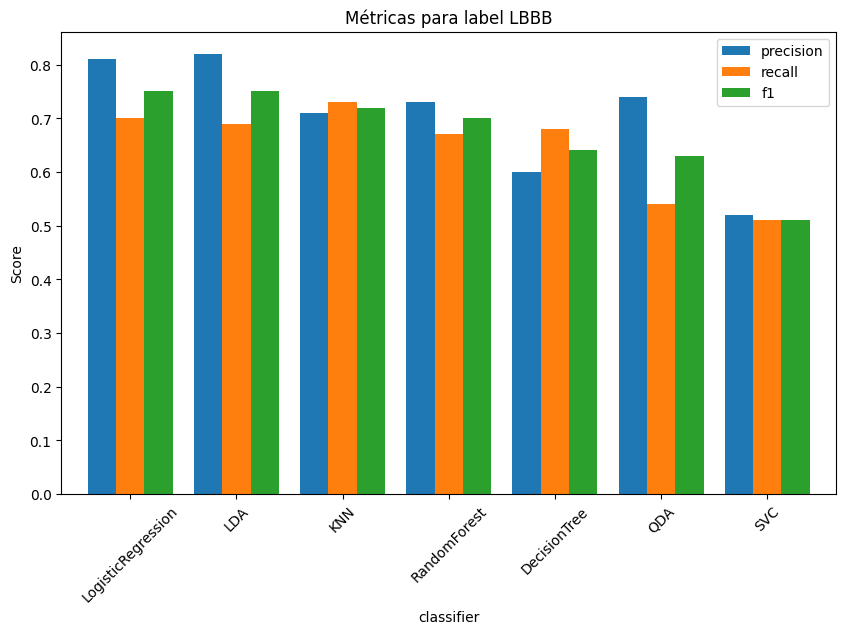

In [1288]:
df_filtered = df_results_per_class[df_results_per_class['label'] == 'LBBB'].sort_values(by='f1', ascending=False)


# Set the classifier as the index for better plotting
df_filtered.set_index('classifier', inplace=True)

# Plotting with rotated x-axis labels
ax = df_filtered[['precision', 'recall', 'f1']].plot(kind='bar', rot=45, figsize=(10, 6), width=0.8)
ax.set_ylabel('Score')
ax.set_title('Métricas para label LBBB')
plt.savefig('./images/classifierchain_LBBB_sick_only.png', bbox_inches='tight')
plt.show()


In [1289]:
#df_results_per_class[df_results_per_class['label'] == 'LBBB'].to_markdown(index=False)

In [1290]:
df_results_per_class[df_results_per_class['label'] == 'SB']

,classifier,label,precision,recall,f1
0,KNN,SB,0.71,0.58,0.64
6,RandomForest,SB,0.86,0.60,0.71
12,LogisticRegression,SB,0.74,0.52,0.61
18,DecisionTree,SB,0.62,0.59,0.61
24,LDA,SB,0.78,0.46,0.58
30,QDA,SB,0.41,0.81,0.54
36,SVC,SB,0.37,0.35,0.36


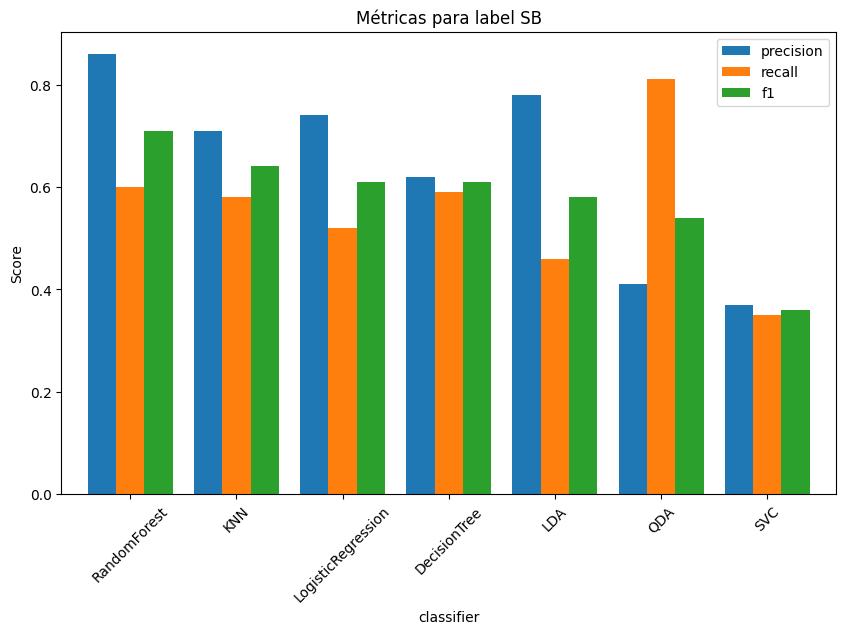

In [1291]:
df_filtered = df_results_per_class[df_results_per_class['label'] == 'SB'].sort_values(by='f1', ascending=False)


# Set the classifier as the index for better plotting
df_filtered.set_index('classifier', inplace=True)

# Plotting with rotated x-axis labels
ax = df_filtered[['precision', 'recall', 'f1']].plot(kind='bar', rot=45, figsize=(10, 6), width=0.8)
ax.set_ylabel('Score')
ax.set_title('Métricas para label SB')
plt.savefig('./images/classifierchain_SB_sick_only.png', bbox_inches='tight')
plt.show()

In [1292]:
#df_results_per_class[df_results_per_class['label'] == 'SB'].to_markdown(index=False)

In [1293]:
df_results_per_class[df_results_per_class['label'] == 'ST']

,classifier,label,precision,recall,f1
3,KNN,ST,0.55,0.64,0.59
9,RandomForest,ST,0.75,0.66,0.70
15,LogisticRegression,ST,0.65,0.56,0.60
21,DecisionTree,ST,0.59,0.57,0.58
27,LDA,ST,0.61,0.57,0.59
33,QDA,ST,0.45,0.47,0.46
39,SVC,ST,0.38,0.26,0.31


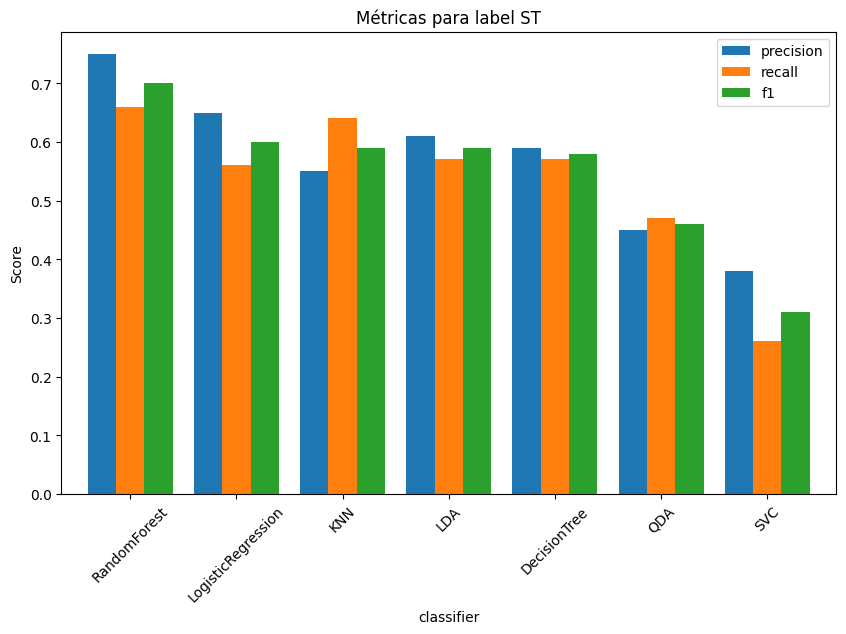

In [1294]:
df_filtered = df_results_per_class[df_results_per_class['label'] == 'ST'].sort_values(by='f1', ascending=False)


# Set the classifier as the index for better plotting
df_filtered.set_index('classifier', inplace=True)

# Plotting with rotated x-axis labels
ax = df_filtered[['precision', 'recall', 'f1']].plot(kind='bar', rot=45, figsize=(10, 6), width=0.8)
ax.set_ylabel('Score')
ax.set_title('Métricas para label ST')
plt.savefig('./images/classifierchain_ST_sick_only.png', bbox_inches='tight')
plt.show()

Novamente a classe LBBB é a classe mais fácil de se classicar e a filtragem de amotras saudáveis para esse problema de classificação parece ter tido um efeito positivo. Além disso, A classe SB mostra valores interessantes para as métricas escolhidas quano se usa o classificador Random Forest.

## Classificação Binária

In [1295]:
def print_metrics_bin(y_test, y_pred):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"f1: {f1}")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix and Metrics: ")
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=True)
    plt.title("Confusion Matrix ")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [1296]:
def get_metrics_bin(y_test, y_pred):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {'precision': precision,
            'recall': recall,
            'f1': f1}

O objetivo dessa seção é classificar se a amostra é saudável ou não. Lembrando que há 3643 doentes e 752 saudáveis.

In [1297]:
y_binary = pd.DataFrame({'isHealthy': ~y.any(axis=1)})
y_binary

,isHealthy
0,False
1,False
2,False
3,False
4,True
...,...
4390,False
4391,False
4392,False
4393,False


Aqui optou-se por retirar igualar o número de amostras doentes e saudáveis, visto que elas poderiam impactar os resultados dessa seção. Além disso, a próxima seção, que adota a estratégia de one class Classification lida com o problema de desbalanceamento das classes. 

In [1298]:
# Check the class distribution before balancing
print("Class distribution before balancing:")
print(y_binary.value_counts())

# Instantiate the RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Fit and apply the undersampling to X and y_binary
X_resampled, y_binary_resampled = undersampler.fit_resample(X, y_binary)

# Check the class distribution after balancing
print("Class distribution after balancing:")
print(y_binary_resampled.value_counts())

Class distribution before balancing:
isHealthy
False        3643
True          752
Name: count, dtype: int64
Class distribution after balancing:
isHealthy
False        752
True         752
Name: count, dtype: int64


In [1299]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_binary_resampled, test_size=0.2, random_state=42)

Criando um dicionário com os classificadores a serem usados. É relevante dizer que os algumas combinações de hiperparâmetros de cada classificador foram testados e na célula abaixo foram escolhidos os valores que acarretaram valores melhores para as métricas escolhidas. 

In [1300]:

binary_classifiers = {
    'KNNeighbors': KNeighborsClassifier(n_neighbors=4),
    'RandomForest': RandomForestClassifier(criterion='log_loss', max_features='log2'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(criterion='gini', max_features='log2'),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'SVC': SVC(kernel='sigmoid'),
}

In [1301]:
df_results = pd.DataFrame(columns=['classifier','label' ,'precision', 'recall', 'f1'])

Cada classficador será treinado e avaliado pelas metricas de precisão, revocação e f1. Lembrando que 1 indica uma pessoa saudável e 0 indica uma pessoa doente.

precision: 0.6774193548387096
recall: 0.5526315789473685
f1: 0.6086956521739131
Confusion Matrix and Metrics: 


/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


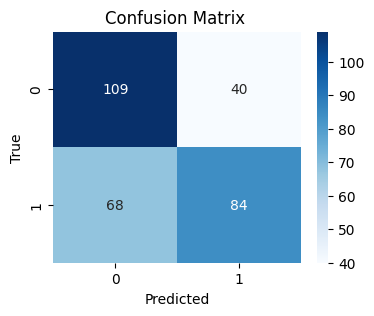

              precision    recall  f1-score   support

       False       0.62      0.73      0.67       149
        True       0.68      0.55      0.61       152

    accuracy                           0.64       301
   macro avg       0.65      0.64      0.64       301
weighted avg       0.65      0.64      0.64       301



In [1302]:
binary_classifiers['KNNeighbors'].fit(X_train, y_train)
y_pred = binary_classifiers['KNNeighbors'].predict(X_test)
print_metrics_bin(y_test, y_pred)
print(classification_report(y_test, y_pred))
df_results.loc[len(df_results)] = {'classifier': 'KNNeighbors', 'label': 'Healthy' ,**get_metrics_bin(y_test, y_pred)}
df_results.loc[len(df_results)] = {'classifier': 'KNNeighbors', 'label': 'Sick', **get_metrics_bin(~y_test, ~y_pred)}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


precision: 0.6687116564417178
recall: 0.7171052631578947
f1: 0.6920634920634919
Confusion Matrix and Metrics: 


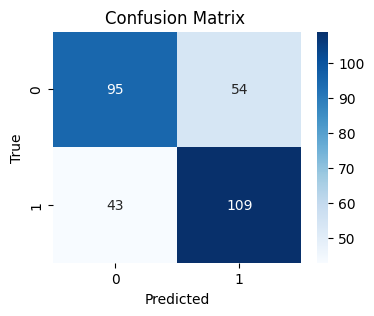

              precision    recall  f1-score   support

       False       0.69      0.64      0.66       149
        True       0.67      0.72      0.69       152

    accuracy                           0.68       301
   macro avg       0.68      0.68      0.68       301
weighted avg       0.68      0.68      0.68       301



In [1303]:
binary_classifiers['RandomForest'].fit(X_train, y_train)
y_pred = binary_classifiers['RandomForest'].predict(X_test)
print_metrics_bin(y_test, y_pred)
print(classification_report(y_test, y_pred))
df_results.loc[len(df_results)] = {'classifier': 'RandomForest','label': 'Healthy' ,**get_metrics_bin(y_test, y_pred)}
df_results.loc[len(df_results)] = {'classifier': 'RandomForest','label': 'Sick', **get_metrics_bin(~y_test, ~y_pred)}

precision: 0.611764705882353
recall: 0.6842105263157895
f1: 0.6459627329192548
Confusion Matrix and Metrics: 


/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


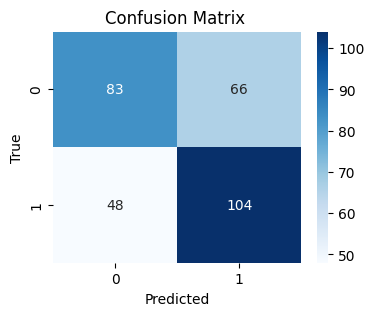

              precision    recall  f1-score   support

       False       0.63      0.56      0.59       149
        True       0.61      0.68      0.65       152

    accuracy                           0.62       301
   macro avg       0.62      0.62      0.62       301
weighted avg       0.62      0.62      0.62       301



In [1304]:
binary_classifiers['LogisticRegression'].fit(X_train, y_train)
y_pred = binary_classifiers['LogisticRegression'].predict(X_test)
print_metrics_bin(y_test, y_pred)
print(classification_report(y_test, y_pred))
df_results.loc[len(df_results)] = {'classifier': 'LogisticRegression','label': 'Healthy' ,**get_metrics_bin(y_test, y_pred)}
df_results.loc[len(df_results)] = {'classifier': 'LogisticRegression','label': 'Sick', **get_metrics_bin(~y_test, ~y_pred)}

precision: 0.5923566878980892
recall: 0.6118421052631579
f1: 0.6019417475728155
Confusion Matrix and Metrics: 


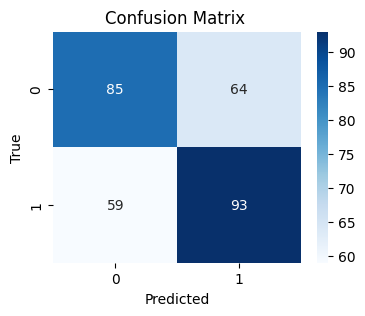

              precision    recall  f1-score   support

       False       0.59      0.57      0.58       149
        True       0.59      0.61      0.60       152

    accuracy                           0.59       301
   macro avg       0.59      0.59      0.59       301
weighted avg       0.59      0.59      0.59       301



In [1305]:
binary_classifiers['DecisionTree'].fit(X_train, y_train)
y_pred = binary_classifiers['DecisionTree'].predict(X_test)
print_metrics_bin(y_test, y_pred)
print(classification_report(y_test, y_pred))
df_results.loc[len(df_results)] = {'classifier': 'DecisionTree','label': 'Healthy' ,**get_metrics_bin(y_test, y_pred)}
df_results.loc[len(df_results)] = {'classifier': 'DecisionTree','label': 'Sick', **get_metrics_bin(~y_test, ~y_pred)}

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


precision: 0.6387096774193548
recall: 0.6513157894736842
f1: 0.6449511400651465
Confusion Matrix and Metrics: 


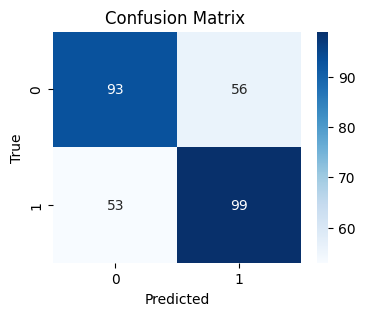

              precision    recall  f1-score   support

       False       0.64      0.62      0.63       149
        True       0.64      0.65      0.64       152

    accuracy                           0.64       301
   macro avg       0.64      0.64      0.64       301
weighted avg       0.64      0.64      0.64       301



In [1306]:
binary_classifiers['LinearDiscriminantAnalysis'].fit(X_train, y_train)
y_pred = binary_classifiers['LinearDiscriminantAnalysis'].predict(X_test)
print_metrics_bin(y_test, y_pred)
print(classification_report(y_test, y_pred))
df_results.loc[len(df_results)] = {'classifier': 'LinearDiscriminantAnalysis','label': 'Healthy' ,**get_metrics_bin(y_test, y_pred)}
df_results.loc[len(df_results)] = {'classifier': 'LinearDiscriminantAnalysis','label': 'Sick', **get_metrics_bin(~y_test, ~y_pred)}

precision: 0.5
recall: 0.07894736842105263
f1: 0.13636363636363635
Confusion Matrix and Metrics: 


/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


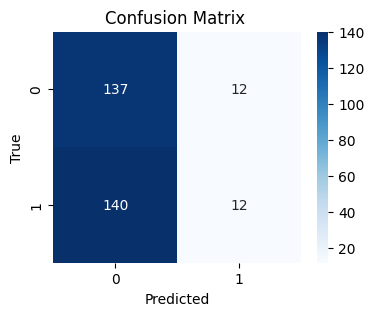

              precision    recall  f1-score   support

       False       0.49      0.92      0.64       149
        True       0.50      0.08      0.14       152

    accuracy                           0.50       301
   macro avg       0.50      0.50      0.39       301
weighted avg       0.50      0.50      0.39       301



In [1307]:
binary_classifiers['QuadraticDiscriminantAnalysis'].fit(X_train, y_train)
y_pred = binary_classifiers['QuadraticDiscriminantAnalysis'].predict(X_test)
print_metrics_bin(y_test, y_pred)
print(classification_report(y_test, y_pred))
df_results.loc[len(df_results)] = {'classifier': 'QuadraticDiscriminantAnalysis','label': 'Healthy' ,**get_metrics_bin(y_test, y_pred)}
df_results.loc[len(df_results)] = {'classifier': 'QuadraticDiscriminantAnalysis','label': 'Sick', **get_metrics_bin(~y_test, ~y_pred)}

precision: 0.5203252032520326
recall: 0.42105263157894735
f1: 0.46545454545454545
Confusion Matrix and Metrics: 


/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


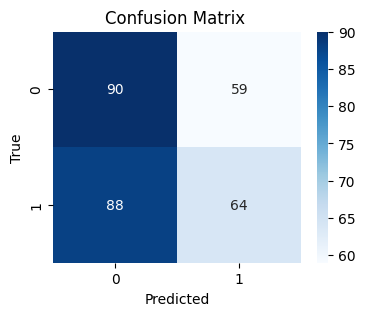

              precision    recall  f1-score   support

       False       0.51      0.60      0.55       149
        True       0.52      0.42      0.47       152

    accuracy                           0.51       301
   macro avg       0.51      0.51      0.51       301
weighted avg       0.51      0.51      0.51       301



In [1308]:
binary_classifiers['SVC'].fit(X_train, y_train)
y_pred = binary_classifiers['SVC'].predict(X_test)
print_metrics_bin(y_test, y_pred)
print(classification_report(y_test, y_pred))
df_results.loc[len(df_results)] = {'classifier': 'SVC','label': 'Healthy' ,**get_metrics_bin(y_test, y_pred)}
df_results.loc[len(df_results)] = {'classifier': 'SVC','label': 'Sick', **get_metrics_bin(~y_test, ~y_pred)}


In [1309]:
df_results

,classifier,label,precision,recall,f1
0,KNNeighbors,Healthy,0.677419,0.552632,0.608696
1,KNNeighbors,Sick,0.615819,0.731544,0.668712
2,RandomForest,Healthy,0.668712,0.717105,0.692063
3,RandomForest,Sick,0.688406,0.637584,0.662021
4,LogisticRegression,Healthy,0.611765,0.684211,0.645963
5,LogisticRegression,Sick,0.633588,0.557047,0.592857
6,DecisionTree,Healthy,0.592357,0.611842,0.601942
7,DecisionTree,Sick,0.590278,0.570470,0.580205
8,LinearDiscriminantAnalysis,Healthy,0.638710,0.651316,0.644951
9,LinearDiscriminantAnalysis,Sick,0.636986,0.624161,0.630508


In [1310]:
float_columns = ['precision', 'recall', 'f1']
df_results[float_columns] = df_results[float_columns].round(2)

In [1311]:
#df_results[df_results['label'] == 'Healthy'].to_markdown(index=False)

In [1312]:
#df_results[df_results['label'] == 'Sick'].to_markdown(index=False)

## One class classification

O objetivo dessa seção é usar a estratégia de One class classification para tentar classificar os doentes/saudáveis e a identificar as pessoas que tem a doença LBBB ou não.

### Doente ou não

In [1313]:
y_binary

,isHealthy
0,False
1,False
2,False
3,False
4,True
...,...
4390,False
4391,False
4392,False
4393,False


Foram testados 4 algoritmos para esse problema: SVM, Isolation Forest, Minimum Covariance Determinant e Local Outlier Factor. Além disso, para cada um desses algorimos considerou-se duas situações: uma em que a classe de doentes é a classe 'inlier' e, portanto, a classe de saudáveis é a 'outlier' e a situação simétrica a essa.

####  saudável -> outlier e doente -> inlier

In [1314]:
df_results = pd.DataFrame(columns=['classifier','label' ,'precision', 'recall', 'f1'])

##### SVM

              precision    recall  f1-score   support

          -1       0.20      0.35      0.26       167
           1       0.82      0.68      0.74       712

    accuracy                           0.62       879
   macro avg       0.51      0.51      0.50       879
weighted avg       0.70      0.62      0.65       879



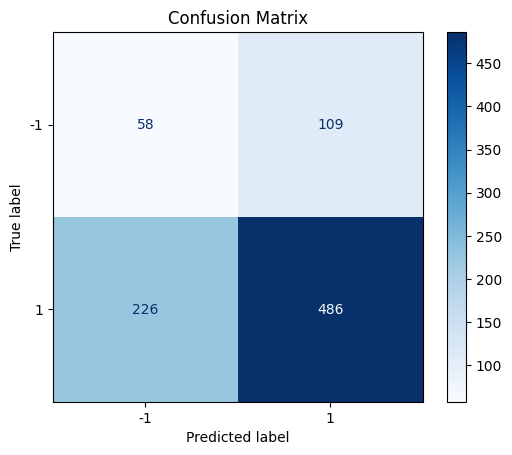

In [1315]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_binary.astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = OneClassSVM(kernel = 'linear', gamma='auto', nu=0.5)
# Selecionando só as amostras negativas (doentes)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 é saudável
y_test_one_class[y_test_one_class == 0] = 1 # 1 é doente  
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'OneClassSVM','label': 'Healthy' ,**get_metrics_bin((-1) * y_test_one_class, (-1) * y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'OneClassSVM','label': 'Sick' ,**get_metrics_bin(y_test_one_class, y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


##### Isolation Forest

              precision    recall  f1-score   support

          -1       0.10      0.05      0.07       167
           1       0.80      0.90      0.85       712

    accuracy                           0.74       879
   macro avg       0.45      0.47      0.46       879
weighted avg       0.67      0.74      0.70       879



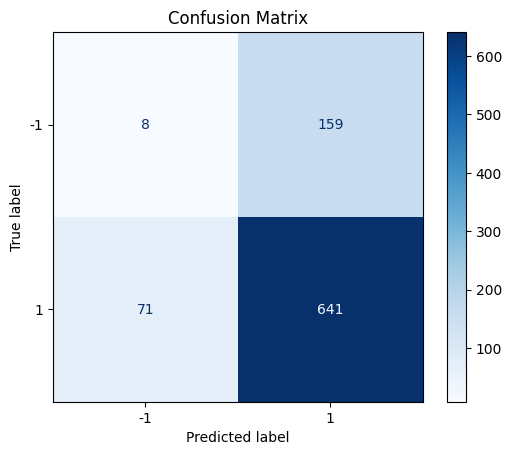

In [1316]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, (y_binary).astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = IsolationForest(n_estimators=100,contamination='auto', random_state=42)
# Selecionando só as amostras negativas (doentes)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 indica doentes
y_test_one_class[y_test_one_class == 0] = 1 # 1 indica saudáveis
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'IsolationForest','label': 'Healthy' ,**get_metrics_bin((-1) * y_test_one_class, (-1) * y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'IsolationForest','label': 'Sick' ,**get_metrics_bin(y_test_one_class, y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


##### Minimum Covariance Determinant

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.17      0.43      0.24       167
           1       0.79      0.50      0.61       712

    accuracy                           0.48       879
   macro avg       0.48      0.46      0.42       879
weighted avg       0.67      0.48      0.54       879



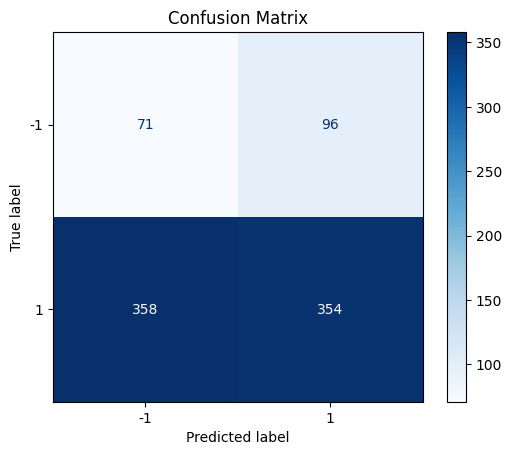

In [1317]:
from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report


#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_binary.astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = EllipticEnvelope(contamination=0.5, random_state=42)
# Selecionando só as amostras negativas (doentes)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 é saudável
y_test_one_class[y_test_one_class == 0] = 1 # 1 é doente
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'EllipticEnvelope','label': 'Healthy' ,**get_metrics_bin((-1) * y_test_one_class, (-1) * y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'EllipticEnvelope','label': 'Sick' ,**get_metrics_bin(y_test_one_class, y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


##### Local Outlier Factor

In [1318]:
def lot_predict(one_class_classifier, X_train_one_class, X_test_one_class):
    # create one large dataset
    composite = np.vstack((X_train_one_class, X_test_one_class))
    # make prediction on composite dataset
    y_pred_one_class = one_class_classifier.fit_predict(composite)
    # return just the predictions on the test set
    return y_pred_one_class[len(X_train_one_class):]

              precision    recall  f1-score   support

          -1       0.36      0.02      0.04       167
           1       0.81      0.99      0.89       712

    accuracy                           0.81       879
   macro avg       0.59      0.51      0.47       879
weighted avg       0.73      0.81      0.73       879



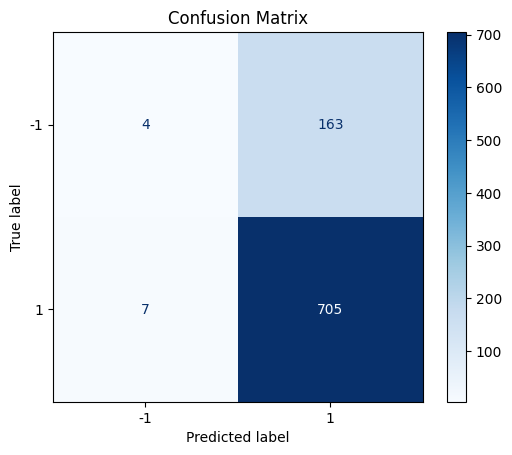

In [1319]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X,  (y_binary).astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = LocalOutlierFactor(n_neighbors=20,algorithm='auto',contamination=0.01)
# Selecionando só as amostras negativas (doentes)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0]
# Treinando o classificador e fazendo predição
y_pred_one_class = lot_predict(one_class_classifier, X_train_one_class, X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 é saudável
y_test_one_class[y_test_one_class == 0] = 1 # 1 é doente
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'LocalOutlierFactor','label': 'Healthy' ,**get_metrics_bin((-1) * y_test_one_class, (-1) * y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'LocalOutlierFactor','label': 'Sick' ,**get_metrics_bin(y_test_one_class, y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [1320]:
df_results

,classifier,label,precision,recall,f1
0,OneClassSVM,Healthy,0.204225,0.347305,0.257206
1,OneClassSVM,Sick,0.816807,0.682584,0.743688
2,IsolationForest,Healthy,0.101266,0.047904,0.065041
3,IsolationForest,Sick,0.801250,0.900281,0.847884
4,EllipticEnvelope,Healthy,0.165501,0.425150,0.238255
5,EllipticEnvelope,Sick,0.786667,0.497191,0.609294
6,LocalOutlierFactor,Healthy,0.363636,0.023952,0.044944
7,LocalOutlierFactor,Sick,0.812212,0.990169,0.892405


In [1321]:
float_columns = ['precision', 'recall', 'f1']
df_results[float_columns] = df_results[float_columns].round(2)

In [1322]:
#df_results[['classifier'] + float_columns].groupby('classifier').mean().round(2).to_markdown()

In [1323]:
#df_results[df_results['label'] == 'Healthy'].to_markdown(index=False)

In [1324]:
#df_results[df_results['label'] == 'Sick'].to_markdown(index=False)

####  saudável -> inlier e doente -> outlier

In [1325]:
df_results = pd.DataFrame(columns=['classifier','label' ,'precision', 'recall', 'f1'])

##### SVM

              precision    recall  f1-score   support

          -1       0.86      0.64      0.74       712
           1       0.26      0.54      0.36       167

    accuracy                           0.63       879
   macro avg       0.56      0.59      0.55       879
weighted avg       0.75      0.63      0.66       879



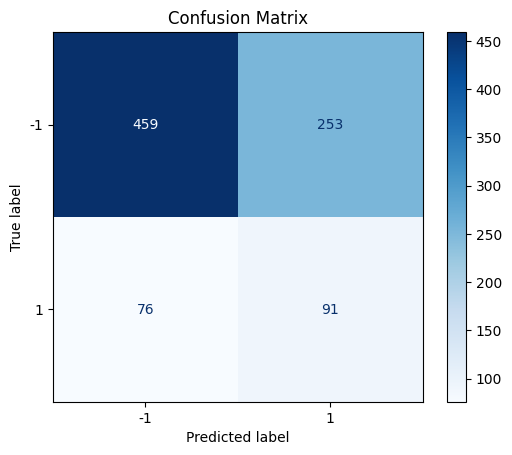

In [1326]:

from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, (~y_binary).astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = OneClassSVM(kernel = 'linear', gamma='auto', nu=0.5)
# Selecionando só as amostras negativas (saudáveis)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 indica doentes
y_test_one_class[y_test_one_class == 0] = 1 # 1 indica saudáveis
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'OneClassSVM','label': 'Healthy' ,**get_metrics_bin( y_test_one_class, y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'OneClassSVM','label': 'Sick' ,**get_metrics_bin((-1) *y_test_one_class,(-1) *  y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


##### Isolation Forest

              precision    recall  f1-score   support

          -1       0.90      0.15      0.25       712
           1       0.20      0.93      0.34       167

    accuracy                           0.30       879
   macro avg       0.55      0.54      0.29       879
weighted avg       0.77      0.30      0.27       879



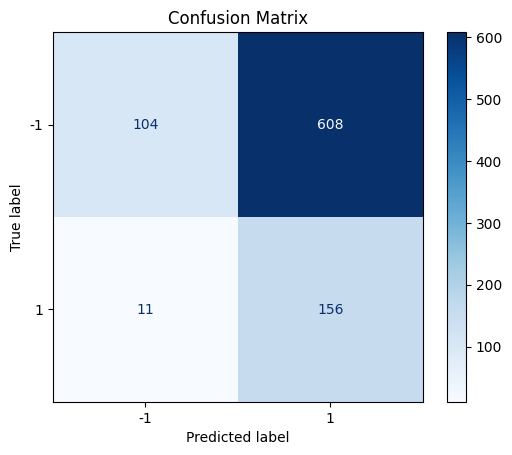

In [1327]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, (~y_binary).astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = IsolationForest(n_estimators=100,contamination='auto', random_state=42)
# Selecionando só as amostras negativas (saudáveis)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 indica doentes
y_test_one_class[y_test_one_class == 0] = 1 # 1 indica saudáveis
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'IsolationForest','label': 'Healthy' ,**get_metrics_bin( y_test_one_class, y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'IsolationForest','label': 'Sick' ,**get_metrics_bin((-1) *y_test_one_class,(-1) *  y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


##### Minimum Covariance Determinant

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.84      0.63      0.72       712
           1       0.24      0.49      0.32       167

    accuracy                           0.61       879
   macro avg       0.54      0.56      0.52       879
weighted avg       0.73      0.61      0.65       879



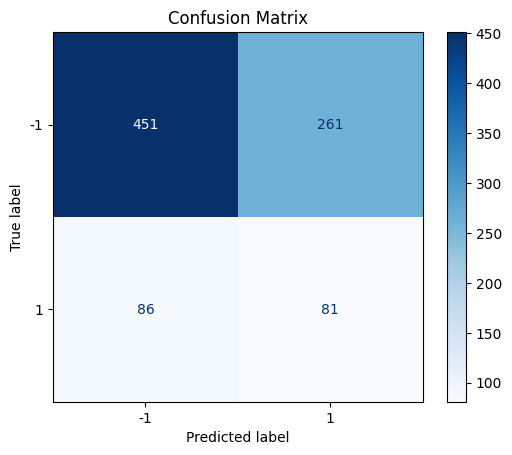

In [1328]:

from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, (~y_binary).astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = EllipticEnvelope(contamination=0.5, random_state=42)
# Selecionando só as amostras negativas (saudáveis)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 indica doentes
y_test_one_class[y_test_one_class == 0] = 1 # 1 indica saudáveis
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'EllipticEnvelope','label': 'Healthy' ,**get_metrics_bin( y_test_one_class, y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'EllipticEnvelope','label': 'Sick' ,**get_metrics_bin((-1) *y_test_one_class,(-1) *  y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


##### Local Outlier Factor

              precision    recall  f1-score   support

          -1       0.62      0.01      0.01       712
           1       0.19      0.98      0.32       167

    accuracy                           0.19       879
   macro avg       0.41      0.49      0.16       879
weighted avg       0.54      0.19      0.07       879



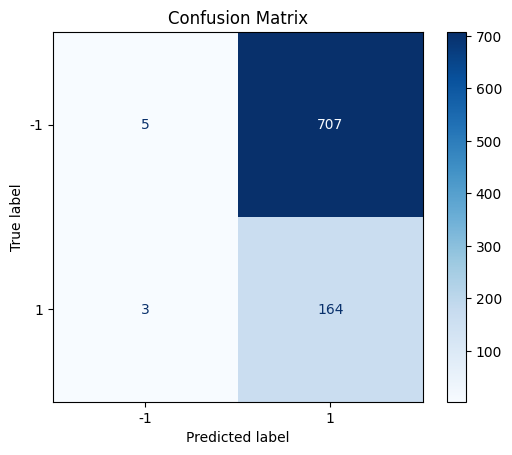

In [1329]:

from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X,  (~y_binary).astype(int).copy(), test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = LocalOutlierFactor(n_neighbors=20,algorithm='auto',contamination=0.01)
# Selecionando só as amostras negativas (saudáveis)
X_train_one_class = X_train_one_class[y_train_one_class.iloc[:, 0] == 0]
# Treinando o classificador e fazendo predição
y_pred_one_class = lot_predict(one_class_classifier, X_train_one_class, X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # -1 indica doentes
y_test_one_class[y_test_one_class == 0] = 1 # 1 indica saudáveis
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'LocalOutlierFactor','label': 'Healthy' ,**get_metrics_bin( y_test_one_class, y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'LocalOutlierFactor','label': 'Sick' ,**get_metrics_bin((-1) *y_test_one_class,(-1) *  y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [1330]:
df_results

,classifier,label,precision,recall,f1
0,OneClassSVM,Healthy,0.264535,0.544910,0.356164
1,OneClassSVM,Sick,0.857944,0.644663,0.736167
2,IsolationForest,Healthy,0.204188,0.934132,0.335124
3,IsolationForest,Sick,0.904348,0.146067,0.251511
4,EllipticEnvelope,Healthy,0.236842,0.485030,0.318271
5,EllipticEnvelope,Sick,0.839851,0.633427,0.722178
6,LocalOutlierFactor,Healthy,0.188289,0.982036,0.315992
7,LocalOutlierFactor,Sick,0.625000,0.007022,0.013889


In [1331]:
float_columns = ['precision', 'recall', 'f1']
df_results[float_columns] = df_results[float_columns].round(2)

In [1332]:
#df_results[['classifier'] + float_columns].groupby('classifier').mean().round(2).to_markdown()

In [1333]:
#df_results[df_results['label'] == 'Healthy'].to_markdown(index=False)

In [1334]:
#df_results[df_results['label'] == 'Sick'].to_markdown(index=False)

### LBBB ou não

Foram testados 4 algoritmos para esse problema: SVM, Isolation Forest, Minimum Covariance Determinant e Local Outlier Factor. Além disso, para cada um desses algorimos considerou-se duas situações: uma em que a classe LBBB é a classe 'inlier' e, portanto, a classe 'não-LBBB' é a 'outlier' e a situação simétrica a essa.

#### LBB -> outlier e não-LBBB -> inlier

In [1335]:
df_results = pd.DataFrame(columns=['classifier','label' ,'precision', 'recall', 'f1'])

##### SVM

              precision    recall  f1-score   support

          -1       0.26      0.96      0.41       140
           1       0.99      0.48      0.65       739

    accuracy                           0.56       879
   macro avg       0.62      0.72      0.53       879
weighted avg       0.87      0.56      0.61       879



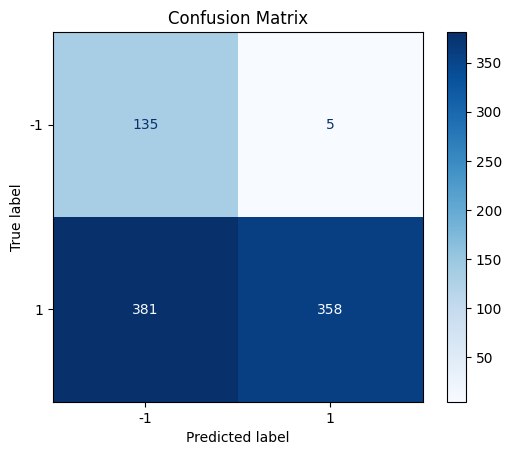

In [1336]:

from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

# selecionando a classe de interesse
y_one_class = y['LBBB'].astype(int).copy()

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = OneClassSVM(kernel = 'linear', gamma='scale', nu=0.5)
# Selecionando só as amostras negativas
X_train_one_class = X_train_one_class[y_train_one_class == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # LBBB
y_test_one_class[y_test_one_class == 0] = 1  # não LBBB
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'OneClassSVM','label': 'LBBB' ,**get_metrics_bin((-1) *y_test_one_class,(-1) *  y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'OneClassSVM','label': 'no-LBBB' ,**get_metrics_bin(y_test_one_class, y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


##### Isolation Forest

              precision    recall  f1-score   support

          -1       0.44      0.36      0.39       140
           1       0.88      0.91      0.90       739

    accuracy                           0.82       879
   macro avg       0.66      0.64      0.65       879
weighted avg       0.81      0.82      0.82       879



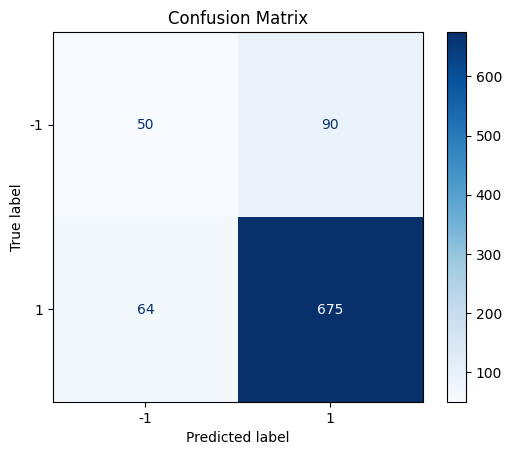

In [1337]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

# selecionando a classe de interesse
y_one_class = y['LBBB'].astype(int).copy()

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = IsolationForest(n_estimators=100,contamination='auto', random_state=42)
# Selecionando só as amostras negativas (não LBBB)
X_train_one_class = X_train_one_class[y_train_one_class == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # LBBB
y_test_one_class[y_test_one_class == 0] = 1 # não LBBB
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'IsolationForest','label': 'LBBB' ,**get_metrics_bin((-1) *y_test_one_class,(-1) *  y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'IsolationForest','label': 'no-LBBB' ,**get_metrics_bin(y_test_one_class, y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


##### Minimum Covariance Determinant

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.24      0.84      0.37       140
           1       0.94      0.50      0.65       739

    accuracy                           0.55       879
   macro avg       0.59      0.67      0.51       879
weighted avg       0.83      0.55      0.61       879



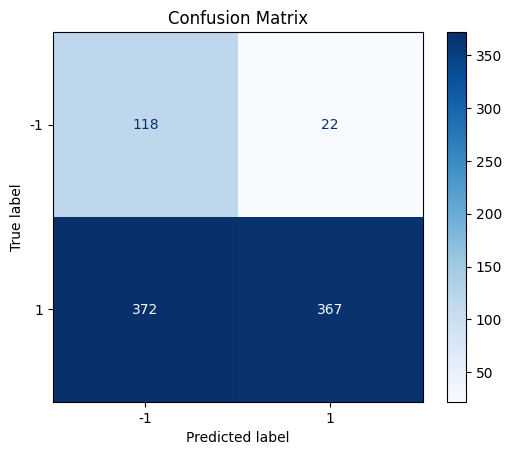

In [1338]:

from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report

# selecionando a classe de interesse
y_one_class = y['LBBB'].astype(int).copy()

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = EllipticEnvelope(contamination=0.5, random_state=42)
# Selecionando só as amostras negativas (não LBBB)
X_train_one_class = X_train_one_class[y_train_one_class == 0] 
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1
y_test_one_class[y_test_one_class == 0] = 1
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'EllipticEnvelope','label': 'LBBB' ,**get_metrics_bin((-1) *y_test_one_class,(-1) *  y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'EllipticEnvelope','label': 'no-LBBB' ,**get_metrics_bin(y_test_one_class, y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


##### Local Outlier Factor

              precision    recall  f1-score   support

          -1       0.11      0.01      0.01       140
           1       0.84      0.99      0.91       739

    accuracy                           0.83       879
   macro avg       0.48      0.50      0.46       879
weighted avg       0.72      0.83      0.77       879



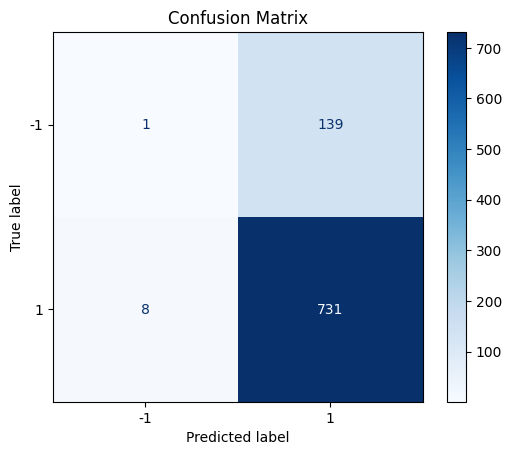

In [1339]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report

def lot_predict(one_class_classifier, X_train_one_class, X_test_one_class):
    # create one large dataset
    composite = np.vstack((X_train_one_class, X_test_one_class))
    # make prediction on composite dataset
    y_pred_one_class = one_class_classifier.fit_predict(composite)
    # return just the predictions on the test set
    return y_pred_one_class[len(X_train_one_class):]

# selecionando a classe de interesse
y_one_class = y['LBBB'].astype(int).copy()

#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = LocalOutlierFactor(n_neighbors=20,algorithm='auto',contamination=0.01)
# Selecionando só as amostras negativas (não LBBB)
X_train_one_class = X_train_one_class[y_train_one_class == 0] 
# Treinando o classificador e fazendo predição
y_pred_one_class = lot_predict(one_class_classifier, X_train_one_class, X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1
y_test_one_class[y_test_one_class == 0] = 1
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'LocalOutlierFactor','label': 'LBBB' ,**get_metrics_bin((-1) *y_test_one_class,(-1) *  y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'LocalOutlierFactor','label': 'no-LBBB' ,**get_metrics_bin(y_test_one_class, y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [1340]:
df_results

,classifier,label,precision,recall,f1
0,OneClassSVM,LBBB,0.261628,0.964286,0.411585
1,OneClassSVM,no-LBBB,0.986226,0.484438,0.649728
2,IsolationForest,LBBB,0.438596,0.357143,0.393701
3,IsolationForest,no-LBBB,0.882353,0.913396,0.897606
4,EllipticEnvelope,LBBB,0.240816,0.842857,0.374603
5,EllipticEnvelope,no-LBBB,0.943445,0.496617,0.650709
6,LocalOutlierFactor,LBBB,0.111111,0.007143,0.013423
7,LocalOutlierFactor,no-LBBB,0.840230,0.989175,0.908639


In [1341]:
float_columns = ['precision', 'recall', 'f1']
df_results[float_columns] = df_results[float_columns].round(2)

In [1342]:
#f_results[['classifier'] + float_columns].groupby('classifier').mean().round(2).to_markdown()

In [1343]:
#df_results[df_results['label'] == 'LBBB'].to_markdown(index=False)

In [1344]:
#df_results[df_results['label'] == 'no-LBBB'].to_markdown(index=False)

#### LBB -> inlier e não-LBBB -> outlier

In [1345]:
df_results = pd.DataFrame(columns=['classifier','label' ,'precision', 'recall', 'f1'])

##### SVM

              precision    recall  f1-score   support

          -1       0.74      0.52      0.61       739
           1       0.01      0.04      0.02       140

    accuracy                           0.44       879
   macro avg       0.38      0.28      0.31       879
weighted avg       0.62      0.44      0.51       879



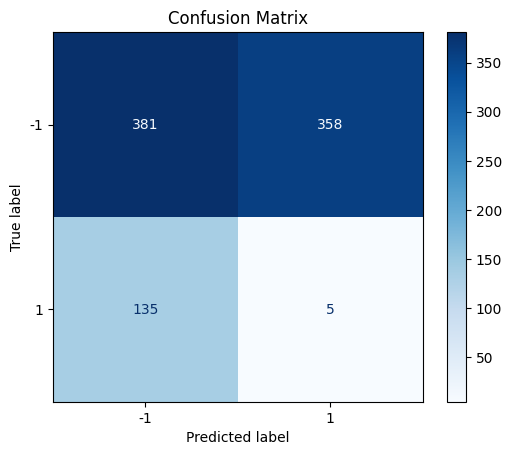

In [1346]:

# Agora as amostras que não apresentam LBBB são os inliers e os que apresentam são outliers
y_one_class = (~y['LBBB']).astype(int).copy()
#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = OneClassSVM(kernel='linear' , gamma='auto', nu=0.5)
# Selecionando só as amostras positivas
X_train_one_class = X_train_one_class[y_train_one_class == 1] # essa linha parece não ter muito impacto
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # não LBBB
y_test_one_class[y_test_one_class == 0] = 1  # LBBB
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'OneClassSVM','label': 'LBBB' ,**get_metrics_bin(y_test_one_class, y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'OneClassSVM','label': 'no-LBBB' ,**get_metrics_bin((-1) *y_test_one_class,(-1) *  y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

##### Isolation Forest

              precision    recall  f1-score   support

          -1       0.53      0.07      0.12       739
           1       0.12      0.69      0.21       140

    accuracy                           0.17       879
   macro avg       0.33      0.38      0.16       879
weighted avg       0.47      0.17      0.13       879



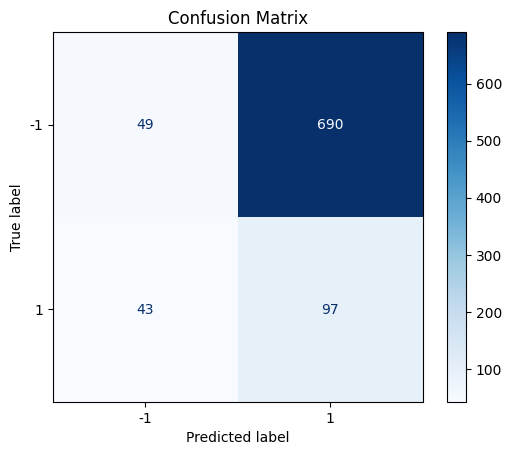

In [1347]:
# Agora as amostras que não apresentam LBBB são os outliers e os que apresentam são inliers
y_one_class = (~y['LBBB']).astype(int).copy()
#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = IsolationForest(n_estimators=100,contamination='auto', random_state=42)
# Selecionando só as amostras positivas (LBBB)
# X_train_one_class = X_train_one_class[y_train_one_class == 1] # essa linha parece não ter muito impacto
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # não LBBB
y_test_one_class[y_test_one_class == 0] = 1  # LBBB
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'IsolationForest','label': 'LBBB' ,**get_metrics_bin(y_test_one_class, y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'IsolationForest','label': 'no-LBBB' ,**get_metrics_bin((-1) *y_test_one_class,(-1) *  y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

##### Minimum Covariance Determinant

/home/araju/anaconda3/envs/vg_classifier/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.75      0.44      0.55       739
           1       0.07      0.21      0.10       140

    accuracy                           0.40       879
   macro avg       0.41      0.33      0.33       879
weighted avg       0.64      0.40      0.48       879



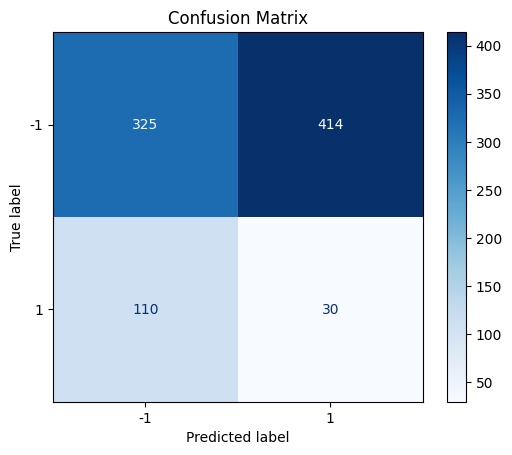

In [1348]:
# Agora as amostras que não apresentam LBBB são os outliers e os que apresentam são inliers
y_one_class = (~y['LBBB']).astype(int).copy()
#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = EllipticEnvelope(contamination=0.5, random_state=42)
# Selecionando só as amostras positivas (LBBB)
# X_train_one_class = X_train_one_class[y_train_one_class == 1] # essa linha parece não ter muito impacto
# Treinando o classificador
one_class_classifier.fit(X_train_one_class)
# Fazendo predição
y_pred_one_class = one_class_classifier.predict(X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # não LBBB
y_test_one_class[y_test_one_class == 0] = 1  # LBBB
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'EllipticEnvelope','label': 'LBBB' ,**get_metrics_bin(y_test_one_class, y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'EllipticEnvelope','label': 'no-LBBB' ,**get_metrics_bin((-1) *y_test_one_class,(-1) *  y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

##### Local Outlier Factor

              precision    recall  f1-score   support

          -1       0.90      0.01      0.02       739
           1       0.16      0.99      0.28       140

    accuracy                           0.17       879
   macro avg       0.53      0.50      0.15       879
weighted avg       0.78      0.17      0.06       879



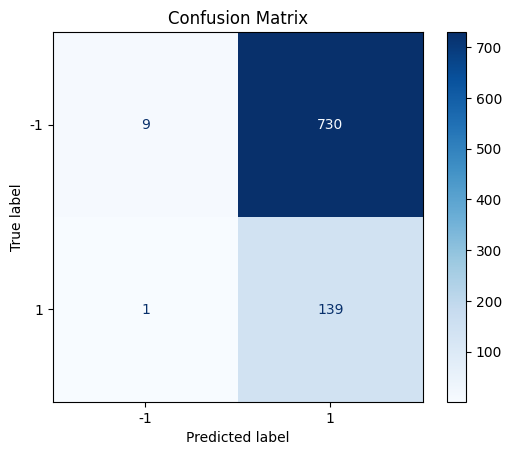

In [1349]:
# Agora as amostras que não apresentam LBBB são os inliers e os que apresentam são outliers
y_one_class = (~y['LBBB']).astype(int).copy()
#Fazendo split
X_train_one_class, X_test_one_class, y_train_one_class, y_test_one_class = train_test_split(X, y_one_class, test_size=0.2, random_state=42)
#Criando Classificador
one_class_classifier = LocalOutlierFactor(n_neighbors=25,algorithm='auto',contamination=0.01)
# Selecionando só as amostras negativas (não LBBB)
X_train_one_class = X_train_one_class[y_train_one_class == 1] 
# Treinando o classificador e fazendo predição
y_pred_one_class = lot_predict(one_class_classifier, X_train_one_class, X_test_one_class)
# -1 indica outliers, 1 indica inliers
y_test_one_class[y_test_one_class == 1] = -1 # não LBBB
y_test_one_class[y_test_one_class == 0] = 1 # LBBB
# Construindo df_results
df_results.loc[len(df_results)] = {'classifier': 'LocalOutlierFactor','label': 'LBBB' ,**get_metrics_bin(y_test_one_class, y_pred_one_class)}
df_results.loc[len(df_results)] = {'classifier': 'LocalOutlierFactor','label': 'no-LBBB' ,**get_metrics_bin((-1) *y_test_one_class,(-1) *  y_pred_one_class)}
# Calculando métricas
print(classification_report(y_test_one_class, y_pred_one_class))
cm = confusion_matrix(y_test_one_class, y_pred_one_class)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [1350]:
df_results

,classifier,label,precision,recall,f1
0,OneClassSVM,LBBB,0.013774,0.035714,0.019881
1,OneClassSVM,no-LBBB,0.738372,0.515562,0.607171
2,IsolationForest,LBBB,0.123253,0.692857,0.209277
3,IsolationForest,no-LBBB,0.532609,0.066306,0.117930
4,EllipticEnvelope,LBBB,0.067568,0.214286,0.102740
5,EllipticEnvelope,no-LBBB,0.747126,0.439783,0.553663
6,LocalOutlierFactor,LBBB,0.159954,0.992857,0.275520
7,LocalOutlierFactor,no-LBBB,0.900000,0.012179,0.024032


In [1351]:
float_columns = ['precision', 'recall', 'f1']
df_results[float_columns] = df_results[float_columns].round(2)

In [1352]:
#df_results[['classifier'] + float_columns].groupby('classifier').mean().round(2).to_markdown()

In [1353]:
#df_results[df_results['label'] == 'LBBB'].to_markdown(index=False)

In [1354]:
#df_results[df_results['label'] == 'no-LBBB'].to_markdown(index=False)

# Resultados e Discussão

Essa seção tem como objetivo apresentar os resultados de maneira mais sucinta e discutí-los. Todas as tabelas nessa seção foram construídas na seção de modelagem. As tabelas e discussões feitas aqui devem contemplar a maioria dos resultados obtidos durante a modelagem, mas as matrized de confusão da seçaõ "Modelagem" podem ser úteis para verificar o output dos classificadores de maneira mais detalhada.

## Multilabel Classification

Nessa seção foi considerado o problema que é classificar qual exame apresenta cada doença. Nesse caso, cada doença é uma propriedade binária e cada exame pode ter de 0 até todas as doenças.

### Cojuntos de dados com e sem doentes

#### Multioutput classifier

| classifier                    | precision_micro | precision_macro | recall_micro | recall_macro | f1_micro | f1_macro | hamming_loss_value |
|-------------------------------|----------------:|----------------:|-------------:|-------------:|---------:|---------:|-------------------:|
| KNNeighbors                   |            0.57 |            0.49 |         0.31 |          0.3 |      0.4 |     0.36 |               0.14 |
| RandomForest                  |         **0.8** |        **0.67** |         0.32 |          0.3 | **0.46** |     0.37 |           **0.12** |
| LogisticRegression            |            0.74 |            0.57 |         0.28 |         0.26 |      0.4 |     0.33 |           **0.12** |
| DecisionTree                  |            0.37 |            0.38 |         0.45 |         0.44 |      0.4 |  **0.4** |                0.2 |
| LinearDiscriminantAnalysis    |            0.71 |            0.54 |         0.23 |         0.22 |     0.34 |     0.28 |               0.13 |
| QuadraticDiscriminantAnalysis |            0.22 |            0.29 |     **0.75** |     **0.75** |     0.35 |     0.38 |               0.43 |
| SVC                           |             0.3 |            0.28 |         0.25 |         0.25 |     0.28 |     0.26 |                0.2 |

| label |    precision |       recall |           f1 |
|-------|-------------:|-------------:|-------------:|
| 1dAVb |     0.11|     0.19 |     0.10|
| AF    |     0.34|     0.14 |         0.12 |
| LBBB  | **0.70** | **0.62** | **0.65** |
| RBBB  |     0.48 |     0.25 |     0.22 |
| SB    |     0.58 |     0.47 |     0.49 |
| ST    |     0.56 |     0.5 |     0.48|

| classifier                    | label | precision |   recall |       f1 |
|-------------------------------|-------|----------:|---------:|---------:|
| KNNeighbors                   | LBBB  |       0.8 |     0.64 |     0.71 |
| RandomForest                  | LBBB  |      0.81 | **0.66** |     0.72 |
| LogisticRegression            | LBBB  |  **0.84** | **0.66** | **0.74** |
| DecisionTree                  | LBBB  |      0.53 |     0.64 |     0.58 |
| LinearDiscriminantAnalysis    | LBBB  |      0.81 |     0.61 |     0.69 |
| QuadraticDiscriminantAnalysis | LBBB  |      0.63 |     0.61 |     0.62 |
| SVC                           | LBBB  |       0.5 |     0.51 |      0.5 |

| classifier                    | label | precision |   recall |       f1 |
|-------------------------------|-------|----------:|---------:|---------:|
| KNNeighbors                   | SB    |      0.64 |      0.4 |     0.49 |
| KNNeighbors                   | 1dAVb |       0.2 |      0.1 |     0.13 |
| KNNeighbors                   | LBBB  |       0.8 |     0.64 |     0.71 |
| KNNeighbors                   | ST    |      0.62 |     0.43 |     0.51 |
| KNNeighbors                   | AF    |      0.17 |     0.04 |     0.07 |
| KNNeighbors                   | RBBB  |       0.5 |     0.17 |     0.25 |
| RandomForest                  | SB    |      0.81 |     0.46 |     0.58 |
| RandomForest                  | 1dAVb |         0 |        0 |        0 |
| RandomForest                  | LBBB  |      0.81 |     0.66 |     0.72 |
| RandomForest                  | ST    |      0.79 |     0.55 |     0.65 |
| RandomForest                  | AF    |       0.6 |     0.02 |     0.04 |
| RandomForest                  | RBBB  |     **1** |     0.14 |     0.24 |
| LogisticRegression            | SB    |      0.73 |     0.38 |      0.5 |
| LogisticRegression            | 1dAVb |         0 |        0 |        0 |
| LogisticRegression            | LBBB  |      0.84 |     0.66 | **0.74** |
| LogisticRegression            | ST    |      0.71 |     0.42 |     0.53 |
| LogisticRegression            | AF    |       0.5 |     0.03 |     0.06 |
| LogisticRegression            | RBBB  |      0.65 |      0.1 |     0.17 |
| DecisionTree                  | SB    |      0.51 |     0.56 |     0.54 |
| DecisionTree                  | 1dAVb |      0.17 |      0.3 |     0.22 |
| DecisionTree                  | LBBB  |      0.53 |     0.61 |     0.56 |
| DecisionTree                  | ST    |      0.56 |     0.62 |     0.59 |
| DecisionTree                  | AF    |      0.21 |     0.23 |     0.22 |
| DecisionTree                  | RBBB  |      0.28 |     0.31 |     0.29 |
| LinearDiscriminantAnalysis    | SB    |      0.74 |     0.39 |     0.51 |
| LinearDiscriminantAnalysis    | 1dAVb |         0 |        0 |        0 |
| LinearDiscriminantAnalysis    | LBBB  |      0.81 |     0.61 |     0.69 |
| LinearDiscriminantAnalysis    | ST    |      0.67 |     0.23 |     0.34 |
| LinearDiscriminantAnalysis    | AF    |       0.5 |     0.02 |     0.04 |
| LinearDiscriminantAnalysis    | RBBB  |      0.54 |     0.05 |      0.1 |
| QuadraticDiscriminantAnalysis | SB    |      0.33 |      0.8 |     0.47 |
| QuadraticDiscriminantAnalysis | 1dAVb |      0.13 |     0.85 |     0.23 |
| QuadraticDiscriminantAnalysis | LBBB  |      0.63 |     0.61 |     0.62 |
| QuadraticDiscriminantAnalysis | ST    |      0.25 | **0.92** |      0.4 |
| QuadraticDiscriminantAnalysis | AF    |      0.19 |     0.53 |     0.28 |
| QuadraticDiscriminantAnalysis | RBBB  |      0.18 |     0.83 |     0.29 |
| SVC                           | SB    |      0.32 |     0.31 |     0.32 |
| SVC                           | 1dAVb |      0.11 |     0.11 |     0.11 |
| SVC                           | LBBB  |       0.5 |     0.51 |      0.5 |
| SVC                           | ST    |      0.36 |     0.28 |     0.31 |
| SVC                           | AF    |      0.15 |     0.08 |     0.11 |
| SVC                           | RBBB  |      0.26 |     0.18 |     0.22 |

Os resultados acima demostram que, em geral, não há resultados muito promissores para nenhum classificador e nenhuma label. Uma exceção é a label LBBB, que parece ter um valores de precisão e revocação interessantes, a depender do classificador. Nesse sentido, a Regressão Logística parece desempenhar um papel razoável na classificação dessa label.

#### ClassifierChain

| classifier                    | precision_micro | precision_macro | recall_micro | recall_macro | f1_micro | f1_macro | hamming_loss_value |
|-------------------------------|----------------:|----------------:|-------------:|-------------:|---------:|---------:|-------------------:|
| KNNeighbors                   |             0.5 |            0.46 |         0.35 |         0.34 |     0.41 |     0.39 |               0.15 |
| RandomForest                  |        **0.77** |        **0.69** |         0.36 |         0.34 | **0.49** | **0.42** |           **0.11** |
| LogisticRegression            |            0.66 |            0.56 |         0.34 |         0.32 |     0.45 |     0.39 |               0.13 |
| DecisionTree                  |            0.38 |            0.38 |     **0.43** |     **0.42** |     0.41 |      0.4 |               0.19 |
| LinearDiscriminantAnalysis    |            0.61 |            0.51 |          0.3 |         0.28 |      0.4 |     0.36 |               0.14 |
| QuadraticDiscriminantAnalysis |            0.25 |             0.3 |          0.6 |          0.6 |     0.35 |     0.35 |               0.33 |
| SVC                           |            0.29 |            0.27 |         0.22 |         0.21 |     0.25 |     0.23 |                0.2 |

| label | precision |   recall |       f1 |
|-------|----------:|---------:|---------:|
| 1dAVb |      0.15 |     0.16 |      0.1 |
| AF    |      0.28 |     0.08 |     0.12 |
| LBBB  |   **0.7** | **0.57** | **0.63** |
| RBBB  |      0.47 |     0.34 |     0.33 |
| SB    |       0.6 |     0.46 |     0.48 |
| ST    |      0.55 |     0.48 |     0.48 |

| classifier                    | label | precision |   recall |       f1 |
|-------------------------------|-------|----------:|---------:|---------:|
| KNNeighbors                   | LBBB  |      0.77 | **0.68** | **0.72** |
| RandomForest                  | LBBB  |      0.79 |     0.64 |      0.7 |
| LogisticRegression            | LBBB  |   **0.8** |     0.66 | **0.72** |
| LinearDiscriminantAnalysis    | LBBB  |   **0.8** |     0.61 |      0.7 |
| QuadraticDiscriminantAnalysis | LBBB  |      0.61 |      0.5 |     0.55 |
| SVC                           | LBBB  |      0.44 |     0.35 |     0.39 |
| SVC                           | LBBB  |       0.5 |     0.51 |      0.5 |

| classifier                    | label | precision |   recall |       f1 |
|-------------------------------|-------|----------:|---------:|---------:|
| KNNeighbors                   | SB    |      0.64 |      0.4 |     0.49 |
| KNNeighbors                   | 1dAVb |      0.22 |     0.13 |     0.16 |
| KNNeighbors                   | LBBB  |      0.77 |     0.68 |     0.72 |
| KNNeighbors                   | ST    |      0.54 |     0.46 |      0.5 |
| KNNeighbors                   | AF    |      0.22 |     0.13 |     0.17 |
| KNNeighbors                   | RBBB  |      0.39 |     0.26 |     0.31 |
| RandomForest                  | SB    |      0.82 |     0.51 |     0.63 |
| RandomForest                  | 1dAVb |      0.25 |     0.02 |     0.03 |
| RandomForest                  | LBBB  |       0.8 |     0.67 | **0.73** |
| RandomForest                  | ST    |      0.76 |     0.55 |     0.64 |
| RandomForest                  | AF    |      0.36 |     0.06 |      0.1 |
| RandomForest                  | RBBB  |  **0.94** |     0.23 |     0.37 |
| LogisticRegression            | SB    |      0.73 |     0.38 |      0.5 |
| LogisticRegression            | 1dAVb |       0.2 |     0.02 |     0.03 |
| LogisticRegression            | LBBB  |       0.8 |     0.66 |     0.72 |
| LogisticRegression            | ST    |      0.69 |     0.47 |     0.56 |
| LogisticRegression            | AF    |      0.34 |     0.09 |     0.15 |
| LogisticRegression            | RBBB  |      0.58 |     0.32 |     0.41 |
| DecisionTree                  | RBBB  |      0.58 |     0.32 |     0.41 |
| LinearDiscriminantAnalysis    | SB    |      0.74 |     0.39 |     0.51 |
| LinearDiscriminantAnalysis    | 1dAVb |      0.13 |     0.02 |     0.03 |
| LinearDiscriminantAnalysis    | LBBB  |       0.8 |     0.61 |      0.7 |
| LinearDiscriminantAnalysis    | ST    |      0.63 |     0.29 |     0.39 |
| LinearDiscriminantAnalysis    | AF    |      0.33 |     0.08 |     0.13 |
| LinearDiscriminantAnalysis    | RBBB  |      0.44 |     0.32 |     0.37 |
| QuadraticDiscriminantAnalysis | SB    |      0.33 |      0.8 |     0.47 |
| QuadraticDiscriminantAnalysis | 1dAVb |      0.12 |     0.63 |     0.21 |
| QuadraticDiscriminantAnalysis | LBBB  |      0.61 |      0.5 |     0.55 |
| QuadraticDiscriminantAnalysis | ST    |      0.36 | **0.86** |     0.51 |
| QuadraticDiscriminantAnalysis | AF    |      0.19 |     0.02 |     0.04 |
| QuadraticDiscriminantAnalysis | RBBB  |      0.18 |     0.77 |     0.29 |
| SVC                           | SB    |      0.32 |     0.31 |     0.32 |
| SVC                           | 1dAVb |      0.12 |     0.13 |     0.12 |
| SVC                           | LBBB  |      0.44 |     0.35 |     0.39 |
| SVC                           | ST    |      0.33 |     0.27 |     0.29 |
| SVC                           | AF    |      0.15 |     0.04 |     0.07 |
| SVC                           | RBBB  |      0.28 |     0.18 |     0.22 |

De maneira análoga aos testes executados para o MultiOuputClassifier, os testes com ClassifierChain não apontam dados muitos promissores, com exceção da label LBBB. Além disso, não percebe-se uma diferença significativa entre os resultados de usando o ClassifierChain e o MultioutputClassifier.

### Conjuntos de dados somente com doentes

#### Multioutput Classifier

| classifier                    | precision_micro | precision_macro | recall_micro | recall_macro | f1_micro | f1_macro | hamming_loss_value |
|-------------------------------|----------------:|----------------:|-------------:|-------------:|---------:|---------:|-------------------:|
| KNNeighbors                   |            0.59 |            0.56 |         0.39 |         0.39 |     0.47 |     0.44 |               0.17 |
| RandomForest                  |        **0.77** |        **0.72** |         0.37 |         0.37 |  **0.5** |     0.44 |           **0.14** |
| LogisticRegression            |            0.76 |            0.66 |         0.31 |         0.31 |     0.44 |     0.38 |               0.15 |
| DecisionTree                  |            0.46 |            0.47 |         0.47 |         0.48 |     0.47 | **0.47** |                0.2 |
| LinearDiscriminantAnalysis    |            0.74 |            0.65 |         0.26 |         0.26 |     0.38 |     0.33 |               0.16 |
| QuadraticDiscriminantAnalysis |             0.3 |            0.36 |     **0.69** |     **0.69** |     0.41 |     0.43 |               0.37 |
| SVC                           |            0.35 |            0.34 |         0.27 |         0.28 |     0.31 |      0.3 |               0.24 |

| label   |   precision |   recall |   f1 |
|:--------|------------:|---------:|-----:|
| 1dAVb   |        0.35 |     0.24 | 0.18 |
| AF      |        0.39 |     0.13 | 0.16 |
| LBBB    |        **0.71** |     **0.63** | **0.66** |
| RBBB    |        0.55 |     0.3  | 0.29 |
| SB      |        0.64 |     0.56 | 0.58 |
| ST      |        0.57 |     0.52 | 0.51 |

| classifier                    | label | precision |   recall |       f1 |
|-------------------------------|-------|----------:|---------:|---------:|
| KNNeighbors                   | LBBB  |      0.75 | **0.69** |     0.72 |
| RandomForest                  | LBBB  |      0.76 |     0.68 |     0.72 |
| LogisticRegression            | LBBB  |      0.82 |     0.66 |     0.73 |
| DecisionTree                  | LBBB  |      0.59 |     0.64 |     0.61 |
| LinearDiscriminantAnalysis    | LBBB  |  **0.83** |     0.67 | **0.74** |
| QuadraticDiscriminantAnalysis | LBBB  |      0.68 |     0.56 |     0.61 |
| SVC                           | LBBB  |      0.52 |     0.49 |     0.51 |

| classifier                    | label | precision |   recall |       f1 |
|-------------------------------|-------|----------:|---------:|---------:|
| KNNeighbors                   | SB    |      0.71 |     0.58 |     0.64 |
| RandomForest                  | SB    |  **0.86** |      0.6 | **0.71** |
| LogisticRegression            | SB    |      0.74 |     0.52 |     0.61 |
| DecisionTree                  | SB    |      0.62 |     0.59 |     0.61 |
| LinearDiscriminantAnalysis    | SB    |      0.78 |     0.46 |     0.58 |
| QuadraticDiscriminantAnalysis | SB    |      0.41 | **0.81** |     0.54 |
| SVC                           | SB    |      0.37 |     0.35 |     0.36 |

| classifier                    | label | precision |   recall |       f1 |
|-------------------------------|-------|----------:|---------:|---------:|
| KNNeighbors                   | SB    |      0.71 |     0.58 |     0.64 |
| KNNeighbors                   | 1dAVb |      0.34 |     0.23 |     0.28 |
| KNNeighbors                   | LBBB  |      0.75 |     0.69 |     0.72 |
| KNNeighbors                   | ST    |      0.62 |     0.56 |     0.59 |
| KNNeighbors                   | AF    |      0.27 |     0.09 |     0.14 |
| KNNeighbors                   | RBBB  |      0.64 |     0.18 |     0.29 |
| RandomForest                  | SB    |      0.86 |      0.6 |     0.71 |
| RandomForest                  | 1dAVb |      0.43 |     0.07 |     0.12 |
| RandomForest                  | LBBB  |      0.76 |     0.68 |     0.72 |
| RandomForest                  | ST    |      0.75 |     0.61 |     0.67 |
| RandomForest                  | AF    |      0.67 |     0.07 |     0.13 |
| RandomForest                  | RBBB  |  **0.87** |     0.18 |      0.3 |
| LogisticRegression            | SB    |      0.74 |     0.52 |     0.61 |
| LogisticRegression            | 1dAVb |       0.5 |     0.02 |     0.03 |
| LogisticRegression            | LBBB  |      0.82 |     0.66 |     0.73 |
| LogisticRegression            | ST    |      0.77 |     0.49 |      0.6 |
| LogisticRegression            | AF    |       0.4 |     0.03 |     0.05 |
| LogisticRegression            | RBBB  |      0.75 |     0.14 |     0.24 |
| DecisionTree                  | SB    |      0.62 |     0.59 |     0.61 |
| DecisionTree                  | 1dAVb |      0.33 |     0.37 |     0.35 |
| DecisionTree                  | LBBB  |      0.59 |     0.64 |     0.61 |
| DecisionTree                  | ST    |      0.58 |     0.57 |     0.57 |
| DecisionTree                  | AF    |      0.29 |     0.32 |      0.3 |
| DecisionTree                  | RBBB  |      0.39 |     0.37 |     0.38 |
| LinearDiscriminantAnalysis    | SB    |      0.78 |     0.46 |     0.58 |
| LinearDiscriminantAnalysis    | 1dAVb |       0.5 |     0.02 |     0.04 |
| LinearDiscriminantAnalysis    | LBBB  |      0.83 |     0.67 | **0.74** |
| LinearDiscriminantAnalysis    | ST    |      0.63 |     0.31 |     0.42 |
| LinearDiscriminantAnalysis    | AF    |       0.5 |     0.02 |     0.04 |
| LinearDiscriminantAnalysis    | RBBB  |      0.65 |     0.09 |     0.16 |
| QuadraticDiscriminantAnalysis | SB    |      0.41 |     0.81 |     0.54 |
| QuadraticDiscriminantAnalysis | 1dAVb |       0.2 |     0.82 |     0.32 |
| QuadraticDiscriminantAnalysis | LBBB  |      0.68 |     0.56 |     0.61 |
| QuadraticDiscriminantAnalysis | ST    |      0.31 | **0.88** |     0.46 |
| QuadraticDiscriminantAnalysis | AF    |      0.32 |      0.2 |     0.24 |
| QuadraticDiscriminantAnalysis | RBBB  |      0.25 |     0.86 |     0.39 |
| SVC                           | SB    |      0.37 |     0.35 |     0.36 |
| SVC                           | 1dAVb |      0.17 |     0.14 |     0.15 |
| SVC                           | LBBB  |      0.52 |     0.49 |     0.51 |
| SVC                           | ST    |      0.36 |     0.25 |     0.29 |
| SVC                           | AF    |      0.29 |     0.17 |     0.21 |
| SVC                           | RBBB  |      0.32 |     0.25 |     0.28 |

Novamente, a classe LBBB mostra-se a mais fácil de se identificar. Ademais, se compararmos o desempenho ao classificar essa classe usando  o MultiOutputClassifier usando somente amostras doentes e amostras doentes e saudáveis, percebe-se uma melhora considerável especialemente para as labels que não são LBBB. 

#### ClassifierChain

| classifier                    | precision_micro | precision_macro | recall_micro | recall_macro | f1_micro | f1_macro | hamming_loss_value |
|-------------------------------|----------------:|----------------:|-------------:|-------------:|---------:|---------:|-------------------:|
| KNNeighbors                   |            0.54 |            0.53 |         0.46 |         0.46 |     0.49 |     0.48 |               0.18 |
| RandomForest                  |        **0.66** |        **0.63** |         0.48 |     **0.48** | **0.55** | **0.54** |           **0.15** |
| LogisticRegression            |            0.53 |            0.54 |         0.47 |         0.47 |      0.5 |     0.48 |               0.18 |
| DecisionTree                  |            0.43 |            0.44 |         0.46 |         0.46 |     0.45 |     0.45 |               0.22 |
| LinearDiscriminantAnalysis    |            0.51 |             0.6 |         0.45 |         0.45 |     0.48 |     0.46 |               0.19 |
| QuadraticDiscriminantAnalysis |            0.31 |            0.37 |     **0.54** |         0.55 |      0.4 |     0.38 |               0.31 |
| SVC                           |            0.36 |            0.33 |         0.23 |         0.23 |     0.28 |     0.26 |               0.22 |

| label   |   precision |   recall |   f1 |
|:--------|------------:|---------:|-----:|
| 1dAVb   |        0.3  |     0.18 | 0.16 |
| AF      |        0.32 |     0.36 | 0.3  |
| LBBB    |        **0.73** |     **0.65** | **0.69** |
| RBBB    |        0.43 |     0.39 | 0.37 |
| SB      |        0.66 |     0.55 | 0.58 |
| ST      |        0.58 |     0.53 | 0.55 |

| classifier                    | label | precision |   recall |       f1 |
|-------------------------------|-------|----------:|---------:|---------:|
| KNNeighbors                   | LBBB  |      0.71 | **0.73** |     0.72 |
| RandomForest                  | LBBB  |      0.73 |     0.67 |      0.7 |
| LogisticRegression            | LBBB  |      0.81 |      0.7 | **0.75** |
| DecisionTree                  | LBBB  |      0.81 |      0.7 | **0.75** |
| LinearDiscriminantAnalysis    | LBBB  |  **0.82** |     0.69 | **0.75** |
| QuadraticDiscriminantAnalysis | LBBB  |      0.74 |     0.54 |     0.63 |
| SVC                           | LBBB  |      0.52 |     0.51 |     0.51 |

| classifier                    | label | precision |   recall |       f1 |
|-------------------------------|-------|----------:|---------:|---------:|
| KNNeighbors                   | SB    |      0.71 |     0.58 |     0.64 |
| RandomForest                  | SB    |  **0.86** |      0.6 | **0.71** |
| LogisticRegression            | SB    |      0.74 |     0.52 |     0.61 |
| DecisionTree                  | SB    |      0.74 |     0.52 |     0.61 |
| LinearDiscriminantAnalysis    | SB    |      0.78 |     0.46 |     0.58 |
| QuadraticDiscriminantAnalysis | SB    |      0.41 | **0.81** |     0.54 |
| SVC                           | SB    |      0.37 |     0.35 |     0.36 |

| classifier                    | label | precision |   recall |       f1 |
|-------------------------------|-------|----------:|---------:|---------:|
| KNNeighbors                   | SB    |      0.71 |     0.58 |     0.64 |
| KNNeighbors                   | 1dAVb |      0.36 |     0.26 |      0.3 |
| KNNeighbors                   | LBBB  |      0.71 |     0.73 |     0.72 |
| KNNeighbors                   | ST    |      0.55 |     0.64 |     0.59 |
| KNNeighbors                   | AF    |      0.32 |     0.25 |     0.28 |
| KNNeighbors                   | RBBB  |      0.52 |     0.27 |     0.35 |
| RandomForest                  | SB    |  **0.86** |      0.6 |     0.71 |
| RandomForest                  | 1dAVb |      0.35 |     0.15 |     0.21 |
| RandomForest                  | LBBB  |      0.73 |     0.67 |      0.7 |
| RandomForest                  | ST    |      0.75 |     0.66 |      0.7 |
| RandomForest                  | AF    |      0.48 |     0.37 |     0.42 |
| RandomForest                  | RBBB  |      0.62 |     0.41 |     0.49 |
| LogisticRegression            | SB    |      0.74 |     0.52 |     0.61 |
| LogisticRegression            | 1dAVb |      0.25 |     0.04 |     0.07 |
| LogisticRegression            | LBBB  |      0.81 |      0.7 | **0.75** |
| LogisticRegression            | ST    |      0.65 |     0.56 |      0.6 |
| LogisticRegression            | AF    |      0.33 |     0.58 |     0.42 |
| LogisticRegression            | RBBB  |      0.44 |      0.4 |     0.42 |
| DecisionTree                  | SB    |      0.74 |     0.52 |     0.61 |
| DecisionTree                  | 1dAVb |      0.25 |     0.04 |     0.07 |
| DecisionTree                  | LBBB  |      0.81 |      0.7 |     0.75 |
| DecisionTree                  | ST    |      0.65 |     0.56 |      0.6 |
| DecisionTree                  | AF    |      0.33 |     0.58 |     0.42 |
| DecisionTree                  | RBBB  |      0.44 |      0.4 |     0.42 |
| LinearDiscriminantAnalysis    | SB    |      0.78 |     0.46 |     0.58 |
| LinearDiscriminantAnalysis    | 1dAVb |      0.57 |     0.03 |     0.06 |
| LinearDiscriminantAnalysis    | LBBB  |      0.82 |     0.69 |     0.75 |
| LinearDiscriminantAnalysis    | ST    |      0.61 |     0.57 |     0.59 |
| LinearDiscriminantAnalysis    | AF    |      0.27 |     0.62 |     0.38 |
| LinearDiscriminantAnalysis    | RBBB  |      0.55 |     0.31 |     0.39 |
| QuadraticDiscriminantAnalysis | SB    |      0.41 |     0.81 |     0.54 |
| QuadraticDiscriminantAnalysis | 1dAVb |      0.18 |     0.61 |     0.27 |
| QuadraticDiscriminantAnalysis | LBBB  |      0.74 |     0.54 |     0.63 |
| QuadraticDiscriminantAnalysis | ST    |      0.45 |     0.47 |     0.46 |
| QuadraticDiscriminantAnalysis | AF    |      0.17 |     0.01 |     0.01 |
| QuadraticDiscriminantAnalysis | RBBB  |      0.26 | **0.83** |     0.39 |
| SVC                           | SB    |      0.37 |     0.35 |     0.36 |
| SVC                           | 1dAVb |      0.17 |      0.1 |     0.13 |
| SVC                           | LBBB  |      0.52 |     0.51 |     0.51 |
| SVC                           | ST    |      0.38 |     0.26 |     0.31 |
| SVC                           | AF    |      0.34 |     0.11 |     0.16 |
| SVC                           | RBBB  |      0.21 |     0.09 |     0.12 |

A LBBB se confirma como a classe mais fácil de identificar e,em geral, não se percebe diferença significativa nos resultados para identificar essa classe, seja na mudança de Multioutput para ClassifierChain, seja mudando a base da dados para saudáveis e doentes para apenas doentes, com exceção de classificadores que obtiveram resultados piores. Nesse caso, a mudança de amostras de dados de doentes e não doentes para somente doentes parece ter efeito positivo. Uma outra classe que chama atenção é a SB, principalmente com o classificador RandomForest. Nesse caso, a mudança de um conjunto de dados com doentes e saudáveis para um conjunto de dados apenas com doentes parece ter um efeito positivo e acarreta em valores interessantes de precisão, recall e f1.

Dessa seção, extrai-se duas linhas de investigação: tentar usar os Classificadores LogisticRegression, RandomForest, LinearDiscriminantAnalysis e KNNeighbors para tentar identificar amostras da classe LBBB usando como cojunto de entrada amostras doentes (apesar de o cojunto de dados com doentes e saudáveis também mostrar reultados frutíferos) e usar o classificador RandomForest em um cojunto de dados somente com amostras doentes, para identificar a label 'SB'.

## Classificação Binária

Nessa seção, buscou-se classificar as amostras em saudáveis e doentes. Para isso, o número de amostras de cada tipo foi equalizado por meio da eliminação aleatória de amostras doentes.

| classifier                    | label   | precision |  recall |       f1 |
|-------------------------------|---------|----------:|--------:|---------:|
| KNNeighbors                   | Healthy |  **0.68** |    0.55 |     0.61 |
| RandomForest                  | Healthy |      0.65 | **0.7** | **0.68** |
| LogisticRegression            | Healthy |      0.61 |    0.68 |     0.65 |
| DecisionTree                  | Healthy |      0.58 |    0.59 |     0.59 |
| LinearDiscriminantAnalysis    | Healthy |      0.64 |    0.65 |     0.64 |
| QuadraticDiscriminantAnalysis | Healthy |       0.5 |    0.08 |     0.14 |
| SVC                           | Healthy |      0.52 |    0.42 |     0.47 |

| classifier                    | label | precision |   recall |       f1 |
|-------------------------------|-------|----------:|---------:|---------:|
| KNNeighbors                   | Sick  |      0.62 |     0.73 | **0.67** |
| RandomForest                  | Sick  |  **0.67** |     0.61 |     0.64 |
| LogisticRegression            | Sick  |      0.63 |     0.56 |     0.59 |
| DecisionTree                  | Sick  |      0.58 |     0.56 |     0.57 |
| LinearDiscriminantAnalysis    | Sick  |      0.64 |     0.62 |     0.63 |
| QuadraticDiscriminantAnalysis | Sick  |      0.49 | **0.92** |     0.64 |
| SVC                           | Sick  |      0.51 |      0.6 |     0.55 |

Novamente, não há dados muito promissores nessa classificação. O único valor realmente alto é recall para classe doente usando a Análise Discriminante Quadrática, mas ele não significa uma alta perfomance desse classificador, pois o recall para classe saudável é baixíssimo. De todos os classificadores testados,  o RandomForest parece ter o melhor desempenho.

## One class classification

Nessa seção, foi adotada a estratégia one class classification para verificar 1) se uma amostra é doente ou não e 2) se uma amostra apresenta a label LBBB ou não. Para cada um desses dois cenários, foram testados 4 algoritmos e foram consideradas duas situações: considerando uma classe como inlier a outra como outlier e vice-versa. Por exemplo, no caso 1) foi considerado a situação em que a classe saudável é a inlier e a doente é a outlier e a situação em que a classe saudável é outlier e a classe doente é a inlier.

### Doente ou não

#### 
saudável -> outlier\
doente -> inlier

| classifier         |   precision |   recall |   f1 |
|:-------------------|------------:|---------:|-----:|
| EllipticEnvelope   |        0.48 |     0.46 | 0.42 |
| IsolationForest    |        0.45 |     0.48 | 0.46 |
| LocalOutlierFactor |        **0.58** |     0.5  | 0.46 |
| OneClassSVM        |        0.51 |     **0.52** | **0.5**  |

| classifier         | label   |   precision |   recall |   f1 |
|:-------------------|:--------|------------:|---------:|-----:|
| OneClassSVM        | Healthy |        0.2  |     0.35 | **0.26** |
| IsolationForest    | Healthy |        0.1  |     0.05 | 0.07 |
| EllipticEnvelope   | Healthy |        0.17 |     **0.43** | 0.24 |
| LocalOutlierFactor | Healthy |        **0.36** |     0.02 | 0.04 |

| classifier         | label   |   precision |   recall |   f1 |
|:-------------------|:--------|------------:|---------:|-----:|
| OneClassSVM        | Sick    |        **0.82** |     0.68 | 0.74 |
| IsolationForest    | Sick    |        0.8  |     0.9  | 0.85 |
| EllipticEnvelope   | Sick    |        0.79 |     0.5  | 0.61 |
| LocalOutlierFactor | Sick    |        0.81 |     **0.99** | **0.89** |

Não há resultados promissores nessa seção. Os valores altos de precisão e recall que ocorrem para a label 'Sick' podem ser explicados pelo fato de que os modelos que apresentaram esses valores desginam muitas amostras para a classe doente e, como ela é a classe majoritária - 3643 doente contra 752 saudáveis - os modelos conseguem acertar uma quantidade considerável de vezes.

#### 
saudável -> inlier\
doente -> outlier

| classifier         |   precision |   recall |   f1 |
|:-------------------|------------:|---------:|-----:|
| EllipticEnvelope   |        0.54 |     0.56 | 0.52 |
| IsolationForest    |        0.55 |     0.54 | 0.3  |
| LocalOutlierFactor |        0.4  |     0.5  | 0.16 |
| OneClassSVM        |        **0.56** |     **0.59** | **0.55** |

| classifier         | label   |   precision |   recall |   f1 |
|:-------------------|:--------|------------:|---------:|-----:|
| OneClassSVM        | Healthy |        **0.26** |     0.54 | **0.36** |
| IsolationForest    | Healthy |        0.2  |     0.93 | 0.34 |
| EllipticEnvelope   | Healthy |        0.24 |     0.49 | 0.32 |
| LocalOutlierFactor | Healthy |        0.19 |     **0.98** | 0.32 |

| classifier         | label   |   precision |   recall |   f1 |
|:-------------------|:--------|------------:|---------:|-----:|
| OneClassSVM        | Sick    |        0.86 |    **0.64** | **0.74** |
| IsolationForest    | Sick    |        **0.9**  |     0.15 | 0.25 |
| EllipticEnvelope   | Sick    |        0.84 |     0.63 | 0.72 |
| LocalOutlierFactor | Sick    |        0.62 |     0.01 | 0.01 |

### LBBB ou não


##### 
LBB -> outlier\
não-LBBB -> inlier

| classifier         |   precision |   recall |   f1 |
|:-------------------|------------:|---------:|-----:|
| EllipticEnvelope   |        0.59 |     0.67 | 0.51 |
| IsolationForest    |        **0.66** |     0.64 | **0.64** |
| LocalOutlierFactor |        0.48 |     0.5  | 0.46 |
| OneClassSVM        |        0.62 |     **0.72** | 0.53 |

| classifier         | label   |   precision |   recall |   f1 |
|:-------------------|:--------|------------:|---------:|-----:|
| OneClassSVM        | LBBB    |        0.26 |     **0.96** | **0.41** |
| IsolationForest    | LBBB    |        **0.44** |     0.36 | 0.39 |
| EllipticEnvelope   | LBBB    |        0.24 |     0.84 | 0.37 |
| LocalOutlierFactor | LBBB    |        0.11 |     0.01 | 0.01 |

| classifier         | label   |   precision |   recall |   f1 |
|:-------------------|:--------|------------:|---------:|-----:|
| OneClassSVM        | no-LBBB |        **0.99** |     0.48 | 0.65 |
| IsolationForest    | no-LBBB |        0.88 |     0.91 | 0.9  |
| EllipticEnvelope   | no-LBBB |        0.94 |     0.5  | 0.65 |
| LocalOutlierFactor | no-LBBB |        0.84 |     **0.99** | **0.91** |

Também não parece haver resultados promissores nessa parte. O valor alto de recall, mas baixo de precisão para a label "LBBB" para o classificador OneClassSVM sugere que o classificador assinalou amostras para a classe LBBB excessivamente. Fora isso, os valores de precisão e recall altos para a label 'no-LBBB' podem ser explicados novamente pela majoritariedade da classe.

##### 
LBB -> inlier\
não-LBBB -> outlier

| classifier         |   precision |   recall |   f1 |
|:-------------------|------------:|---------:|-----:|
| EllipticEnvelope   |        0.41 |     0.32 | **0.32** |
| IsolationForest    |        0.32 |     0.38 | 0.16 |
| LocalOutlierFactor |        **0.53** |     **0.5**  | 0.15 |
| OneClassSVM        |        0.38 |     0.28 | **0.32** |

| classifier         | label   |   precision |   recall |   f1 |
|:-------------------|:--------|------------:|---------:|-----:|
| OneClassSVM        | LBBB    |        0.01 |     0.04 | 0.02 |
| IsolationForest    | LBBB    |        0.12 |     0.69 | 0.21 |
| EllipticEnvelope   | LBBB    |        0.07 |     0.21 | 0.1  |
| LocalOutlierFactor | LBBB    |        **0.16** |     **0.99**| **0.28** |

| classifier         | label   |   precision |   recall |   f1 |
|:-------------------|:--------|------------:|---------:|-----:|
| OneClassSVM        | no-LBBB |        0.74 |     **0.52** | **0.61** |
| IsolationForest    | no-LBBB |        0.53 |     0.07 | 0.12 |
| EllipticEnvelope   | no-LBBB |        0.75 |     0.44 | 0.55 |
| LocalOutlierFactor | no-LBBB |        **0.9** |     0.01 | 0.02 |

Também não há resultados muito promissores nessa parte. Além disso, considerar a classe LBBB como inlier parece ter um efeito prejudicial nesse caso.

A estratégia de OneClass Classification tem um desempenho pior se comparado com a estratégia de Multilabel classification para identificar classes LBBB. Uma razão que pode explicar esse fato é que a primeira estratégia é usada para quando há um desbalancemento muito grande entre a classe positiva e negativa. E no caso do conjunto de dados usados, há 736 amostras LBBB e 3695 amostras não-LBBB - uma relação de 1 para 5 - o que talvez não seja um desbalanceamento grande o suficiente para que a abordagem de OneClass classification funcione de maneira adequada. O mesmo raciocínio vale para a classificação de doentes e não doentes.
